In [2]:
#импорт начальных библиотек
import arviz as az
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))

warnings.filterwarnings("ignore")

In [3]:
from pymc3 import Data, Exponential, HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample, sample_posterior_predictive, set_data
import theano

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error

In [168]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [110]:
#загрузка данных
data_file_path = './data/train.csv'
df = pd.read_csv(data_file_path)

In [7]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

All the targets are none nulls

In [7]:
df.SalePrice.isna().sum()

0

In [111]:
target = 'SalePrice'

num_cols = ["LotFrontage", "LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
           "1stFlrSF","2ndFlrSF","GrLivArea","TotRmsAbvGrd","Fireplaces","GarageCars",
           "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","ScreenPorch"]
cat_cols = ["MSSubClass", "MSZoning", "Street", "LotShape", "LandContour","LotConfig", 
            "LandSlope","Neighborhood","Condition1","BldgType","HouseStyle","OverallCond",
            "OverallQual","RoofStyle","Exterior1st","Exterior2nd","MasVnrType","ExterQual",
            "ExterCond","Foundation","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1",
           "BsmtFinType2","HeatingQC","CentralAir","Electrical","BsmtFullBath","FullBath",
           "HalfBath","BedroomAbvGr","KitchenQual","FireplaceQu","GarageType","GarageFinish",
           "GarageQual","GarageCond","PavedDrive","Fence","YrSold2008","SaleType","SaleCondition"]

RANDOM_SEED = 8927

### EDA

In [10]:
def show_distriubutions_for_num(feature: str):
    fig, axes = plt.subplots(nrows = 1, ncols =3, figsize = ( 20 , 5 ))
    sns.scatterplot(data=df, x=feature, y='SalePrice', ax = axes[2])
    sns.distplot(df[feature],   ax = axes[0])
    sns.boxenplot(data=df, x=feature, ax = axes[1])
    axes[0].set_title(f"{feature} distribution")
    axes[1].set_title(f"{feature} outliers")
    axes[2].set_title("Target distribution")
    plt.show()

In [11]:
def show_distributions_for_cat(feature: str):
    dfgm = df.groupby(by=feature).size()
    fig, axes = plt.subplots(nrows = 1, ncols =2, figsize = ( 15 , 5 ))
    sns.barplot(dfgm.index, dfgm.values, fill=True, palette=sns.color_palette('bright')[:5],  saturation=0.45, ax=axes[0])
    dfgm = df.groupby(by=feature)["SalePrice"].agg("mean")
    sns.barplot(dfgm.index, dfgm.values, fill=True, palette=sns.color_palette('bright')[:5],  saturation=0.45, ax=axes[1])
    axes[1].set_title(f"Average sales price by {feature}")
    axes[0].set_title(f"{feature} histogramm")
    plt.show()    

LotFrontage

In [149]:
df["LotFrontage"].isna().sum()

259

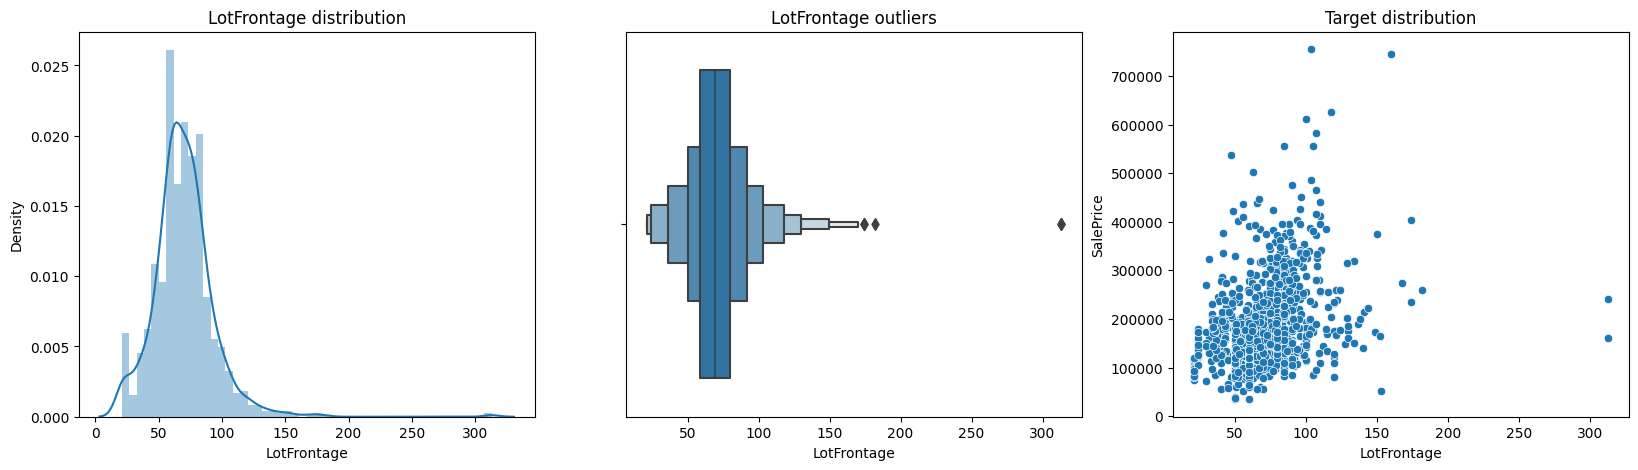

In [142]:
show_distriubutions_for_num('LotFrontage')

MSSubClass

In [312]:
df["MSSubClass"].isna().sum()

0

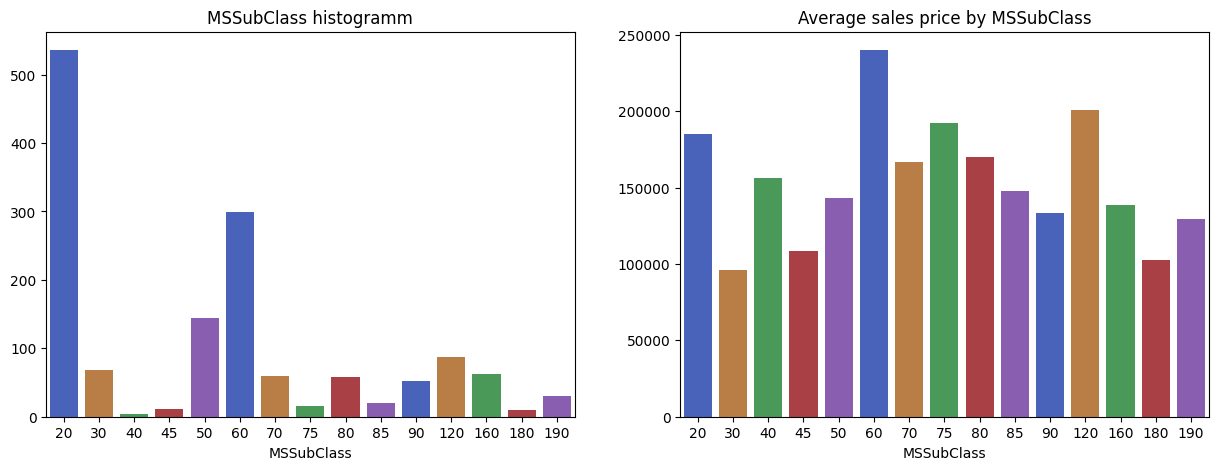

In [148]:
show_distributions_for_cat("MSSubClass")

LotArea

In [150]:
df["LotArea"].isna().sum()

0

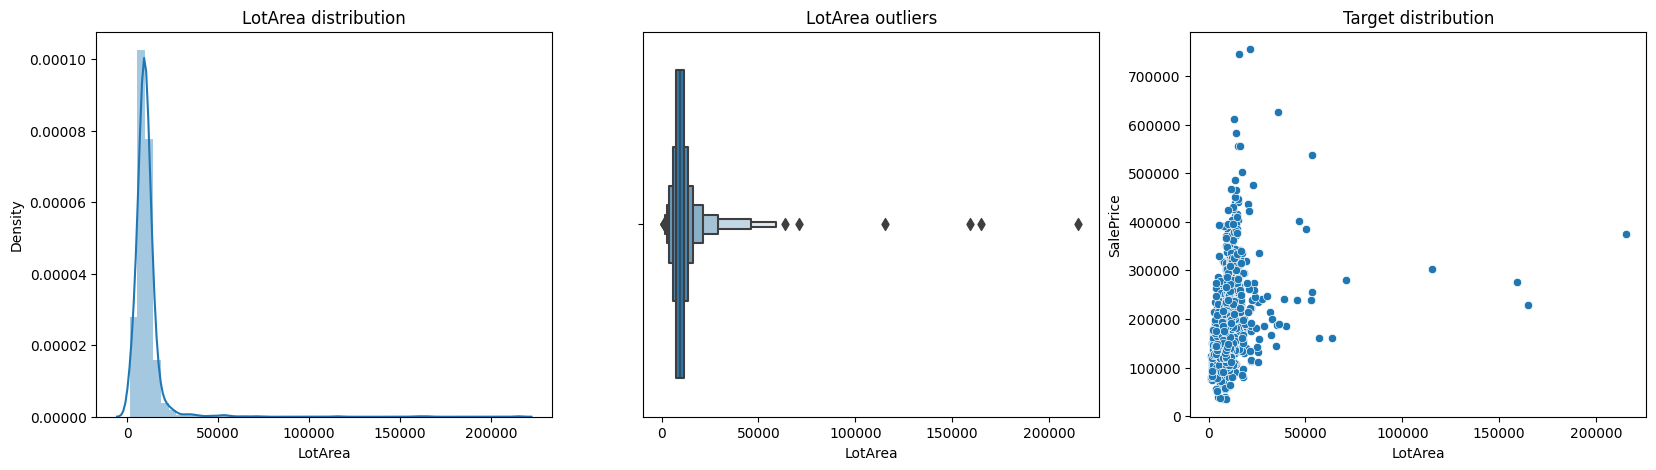

In [151]:
show_distriubutions_for_num('LotArea')

MSZoning

In [152]:
df["MSZoning"].isna().sum()

0

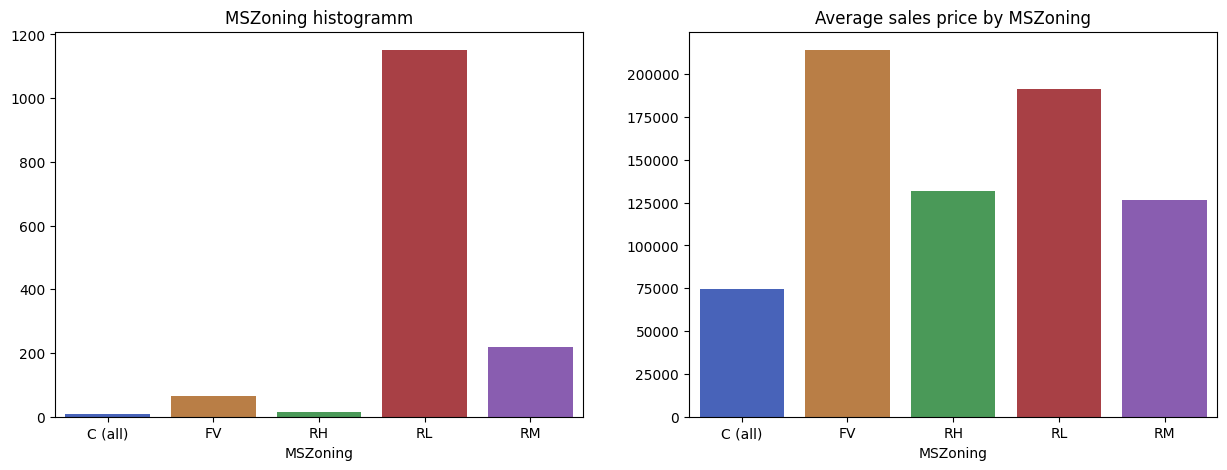

In [153]:
show_distributions_for_cat("MSZoning")

Street

In [163]:
df["Street"].isna().sum()

0

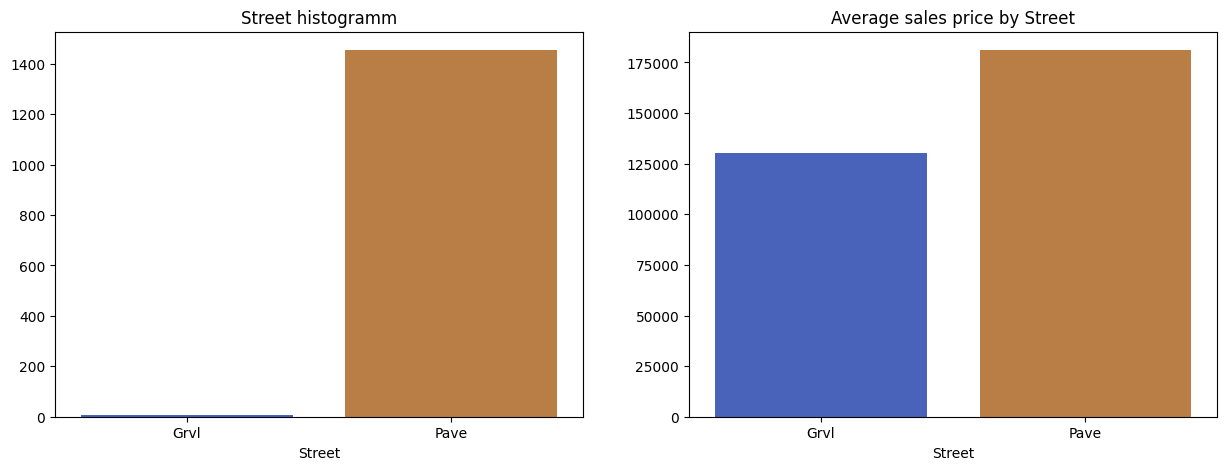

In [164]:
show_distributions_for_cat("Street")

Alley

In [181]:
df["Alley"].isna().sum()

1369

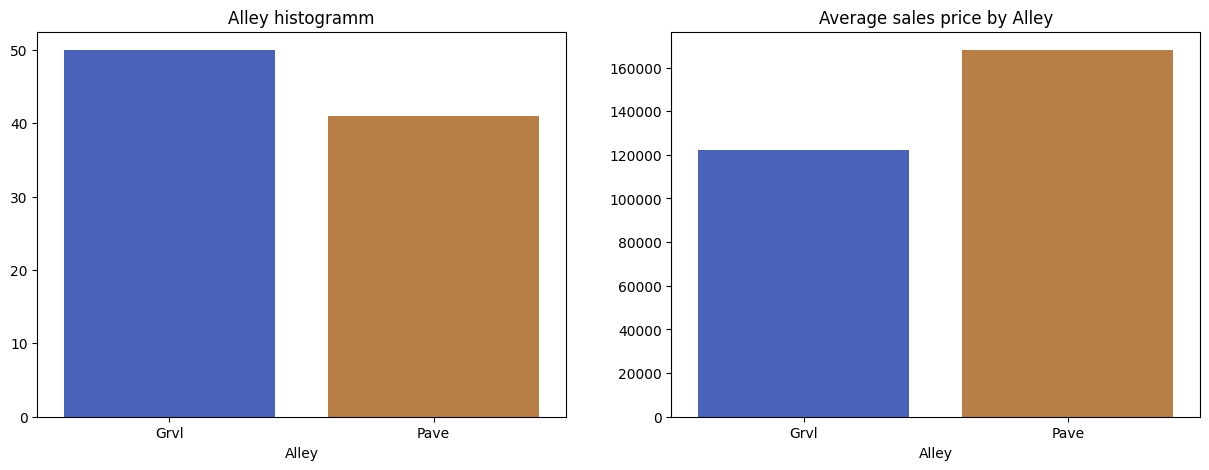

In [183]:
show_distributions_for_cat("Alley")

In [ ]:
df["Alley"].isna().sum()

LotShape

In [185]:
df["LotShape"].isna().sum()

0

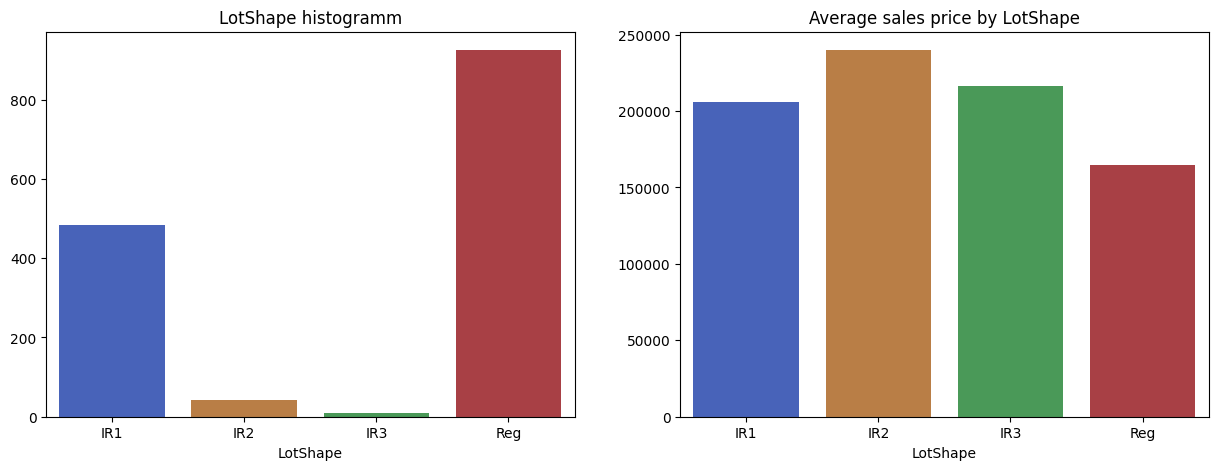

In [186]:
show_distributions_for_cat("LotShape")

LandContour

In [192]:
df["LandContour"].isna().sum()

0

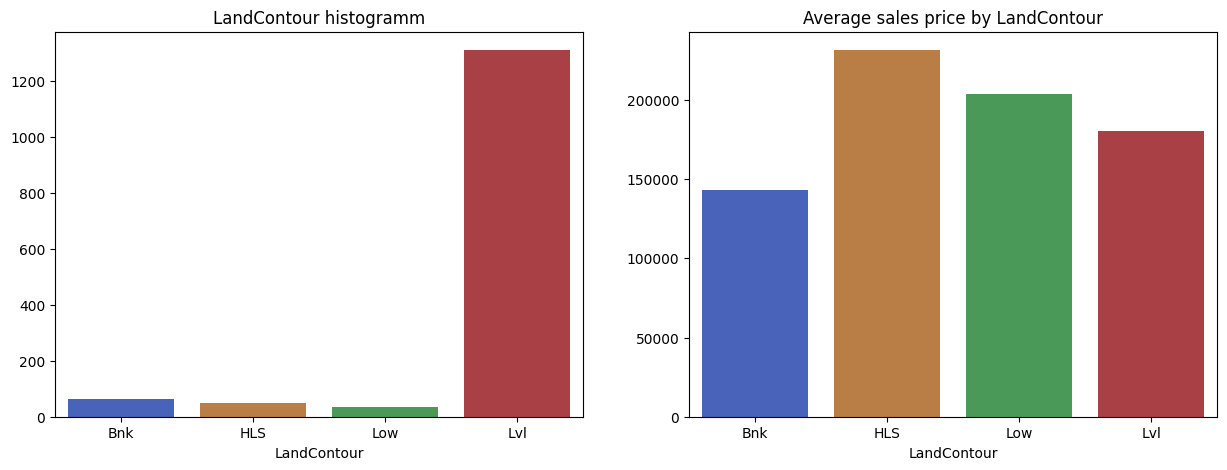

In [193]:
show_distributions_for_cat("LandContour")

Utilities

In [200]:
df["Utilities"].isna().sum()

0

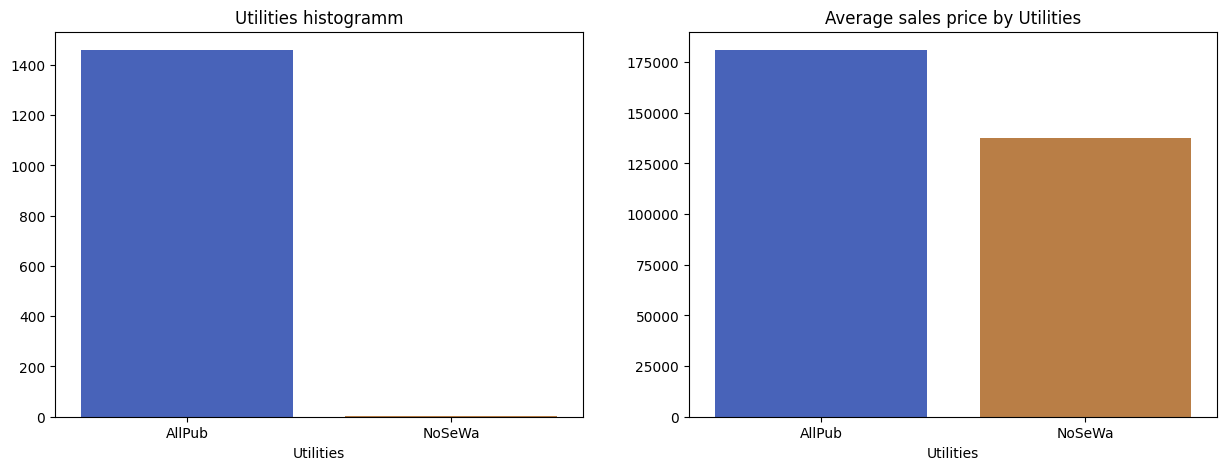

In [201]:
show_distributions_for_cat("Utilities")

LotConfig

In [202]:
df["LotConfig"].isna().sum()

0

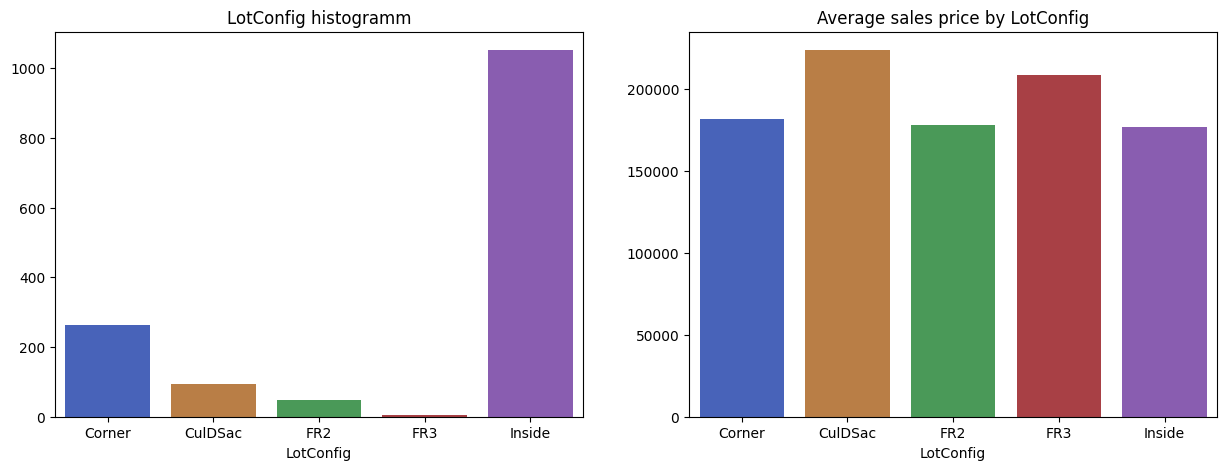

In [203]:
show_distributions_for_cat("LotConfig")

LandSlope

In [216]:
df["LandSlope"].isna().sum()

0

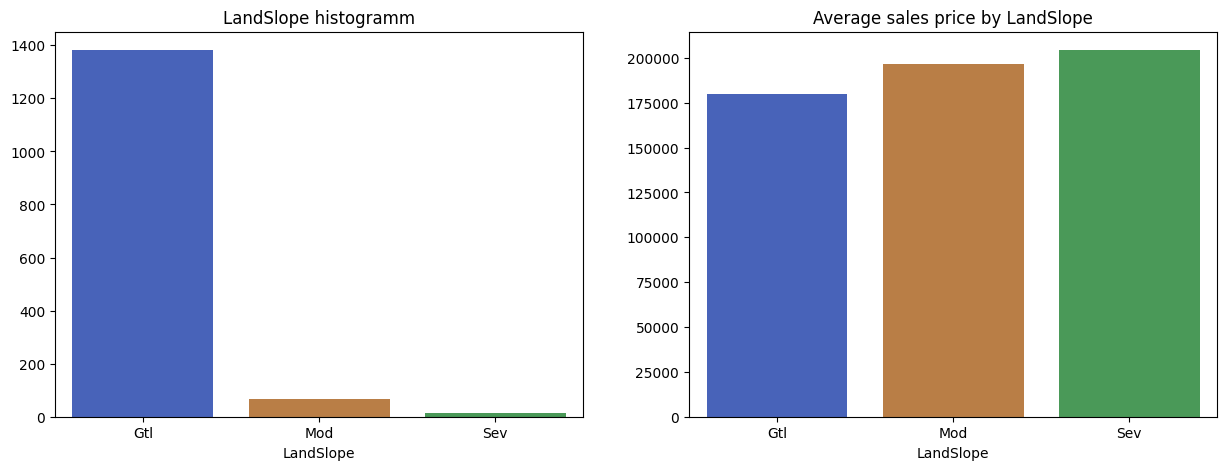

In [217]:
show_distributions_for_cat("LandSlope")

Neighborhood

In [231]:
df["Neighborhood"].isna().sum()

0

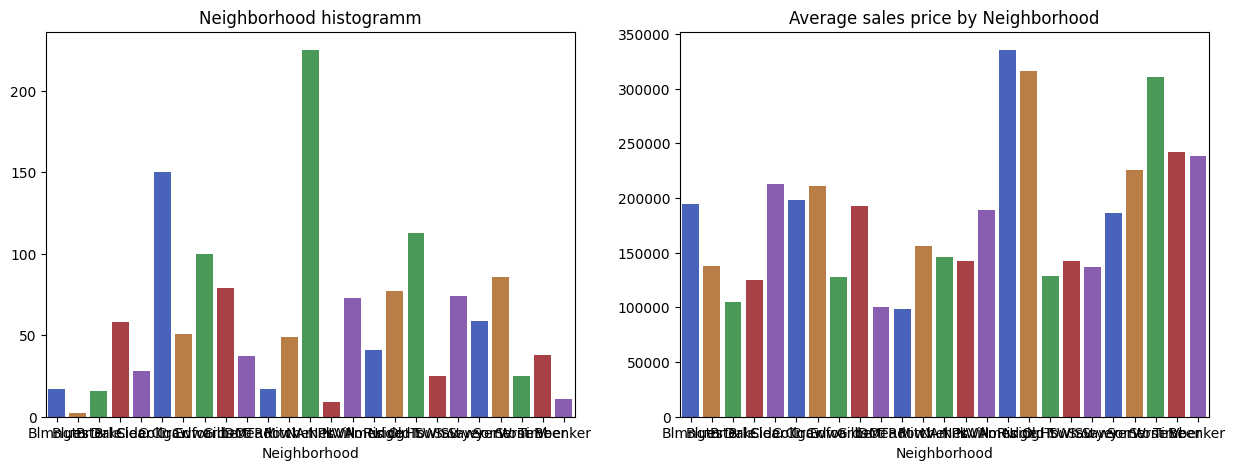

In [232]:
show_distributions_for_cat("Neighborhood")

Condition1

In [234]:
df["Condition1"].isna().sum()

0

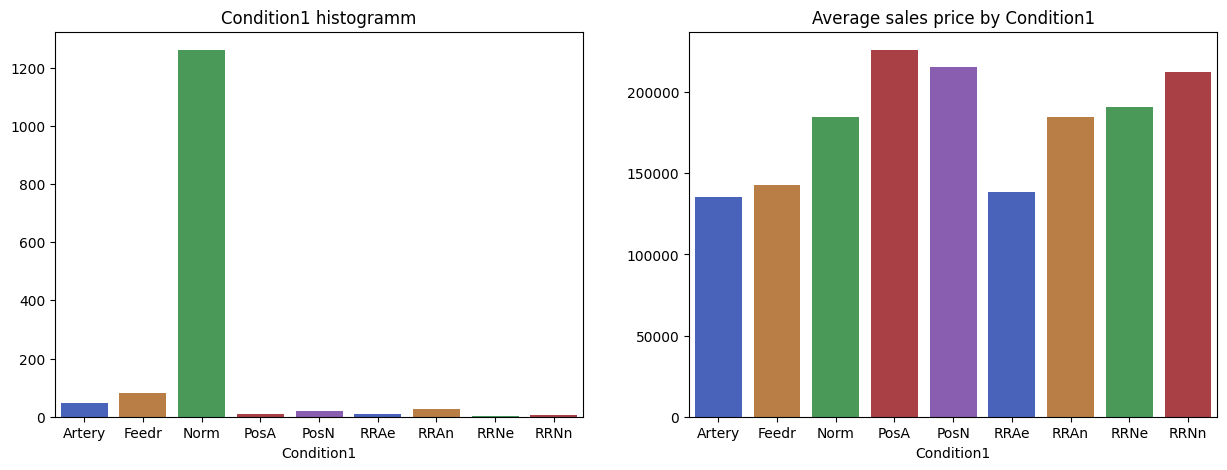

In [237]:
show_distributions_for_cat("Condition1")

Condition2

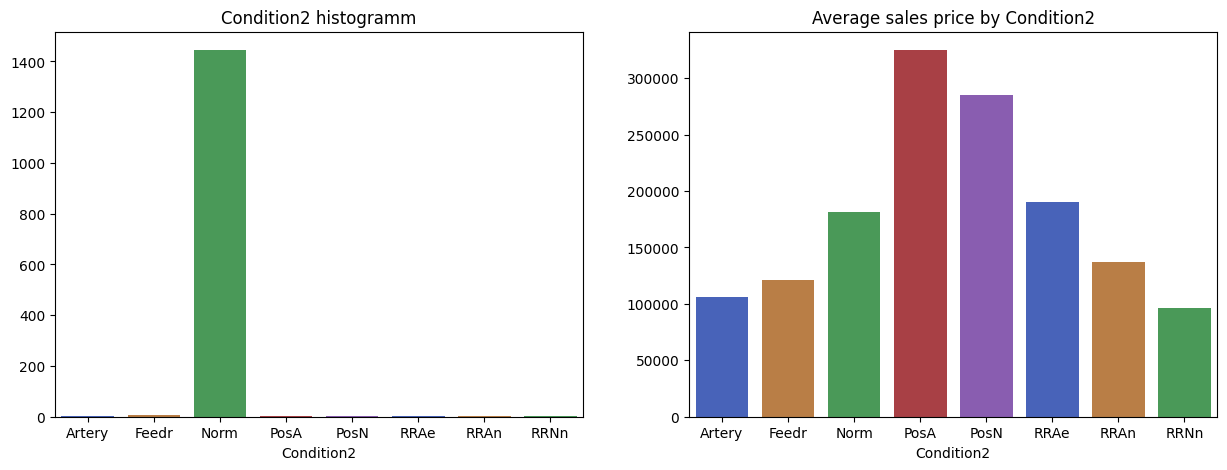

In [243]:
show_distributions_for_cat("Condition2")

Will skip Condition2 as majority of iteams are grouped in one bin

BldgType

In [244]:
df["BldgType"].isna().sum()

0

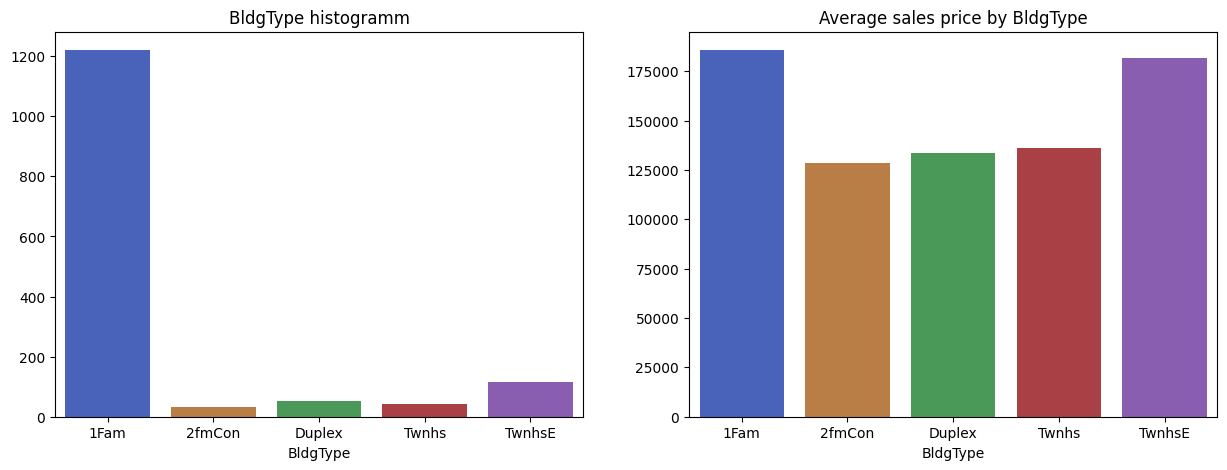

In [245]:
show_distributions_for_cat("BldgType")

Lets goup 1Fam+TwnhsE and 2fmCon+Duplex+Twnhs

HouseStyle

In [261]:
df["HouseStyle"].isna().sum()

0

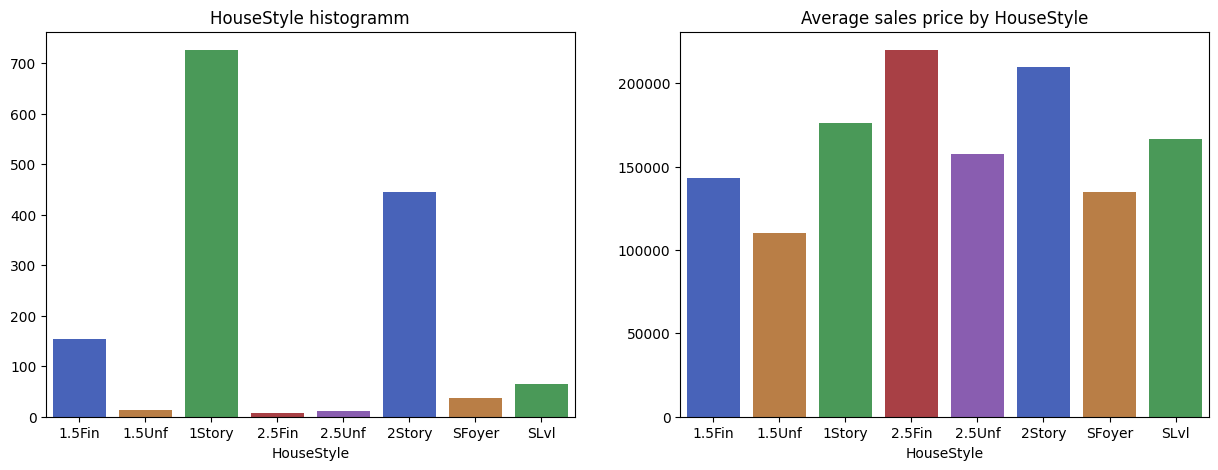

In [262]:
show_distributions_for_cat("HouseStyle")

OverallQual

In [268]:
df["OverallQual"].isna().sum()

0

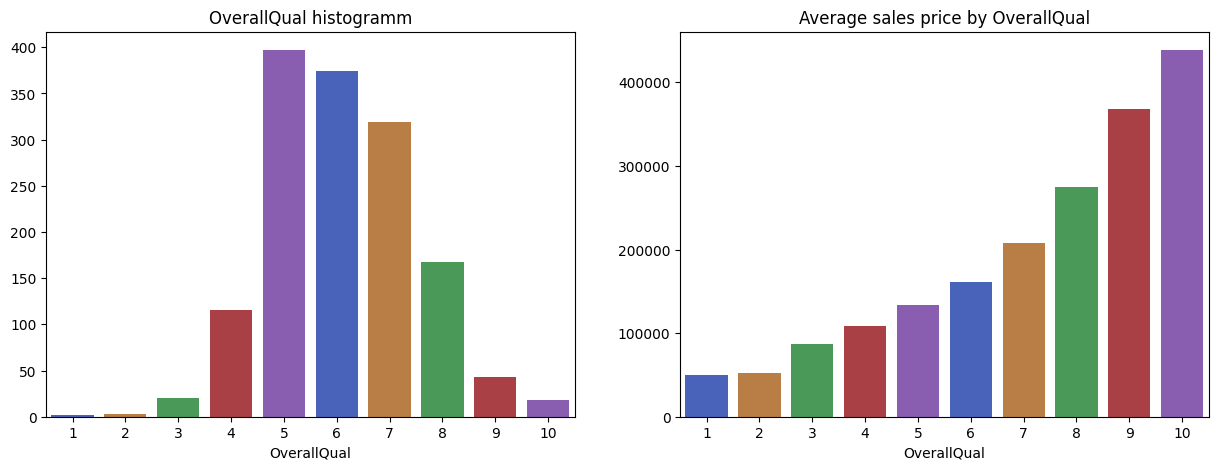

In [269]:
show_distributions_for_cat("OverallQual")

OverallCond

In [276]:
df["OverallCond"].isna().sum()

0

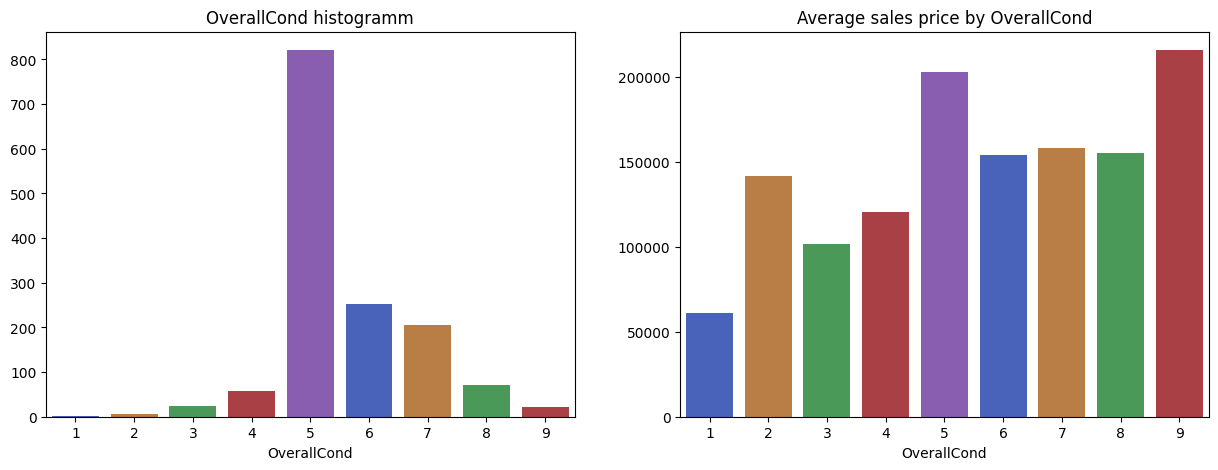

In [277]:
show_distributions_for_cat("OverallCond")

RoofStyle

In [283]:
df["RoofStyle"].isna().sum()

0

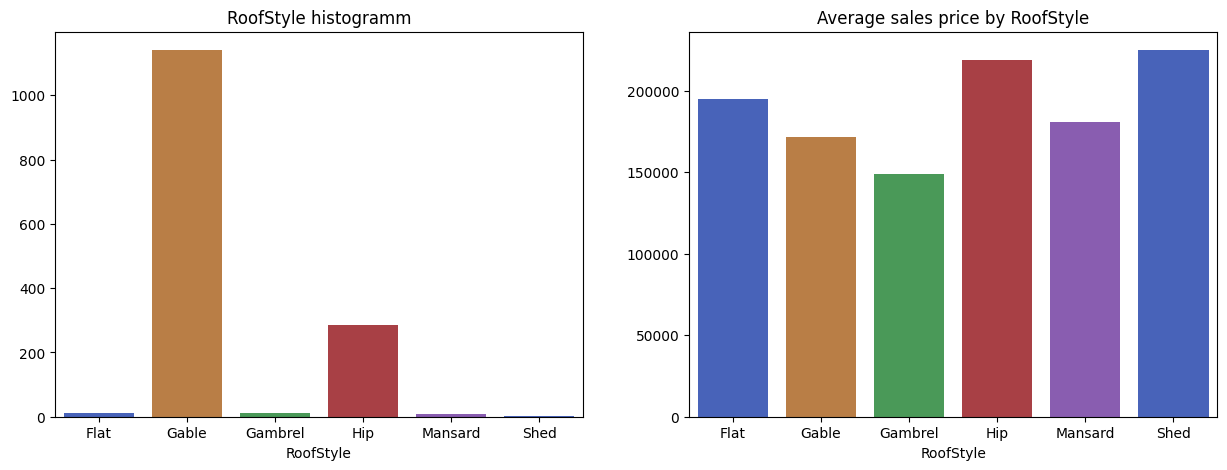

In [284]:
show_distributions_for_cat("RoofStyle")

RoofMatl

In [289]:
df["RoofMatl"].isna().sum()

0

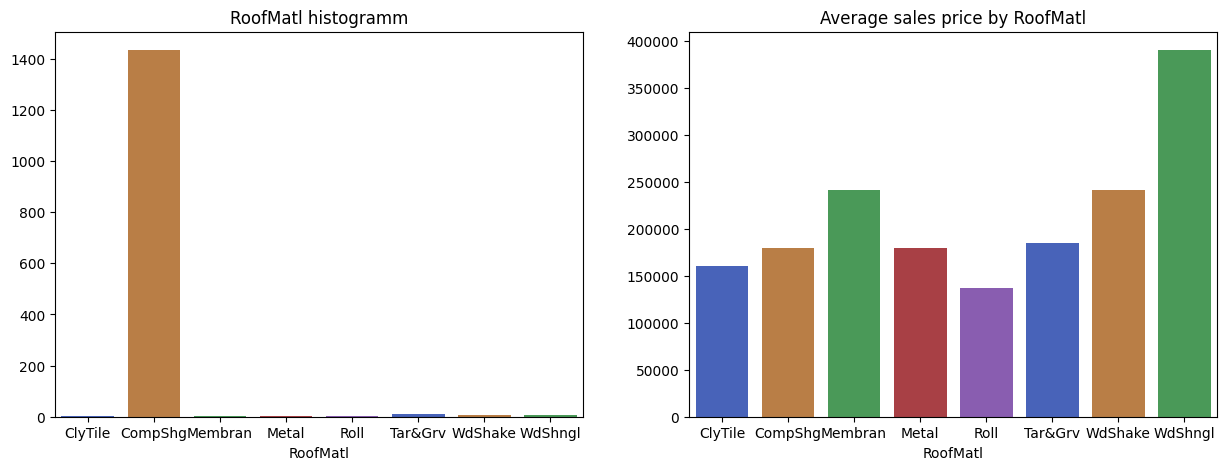

In [290]:
show_distributions_for_cat("RoofMatl")

Will skip RoofMatl as majority of iteams are grouped in one bin

Exterior1st

In [291]:
df["Exterior1st"].isna().sum()

0

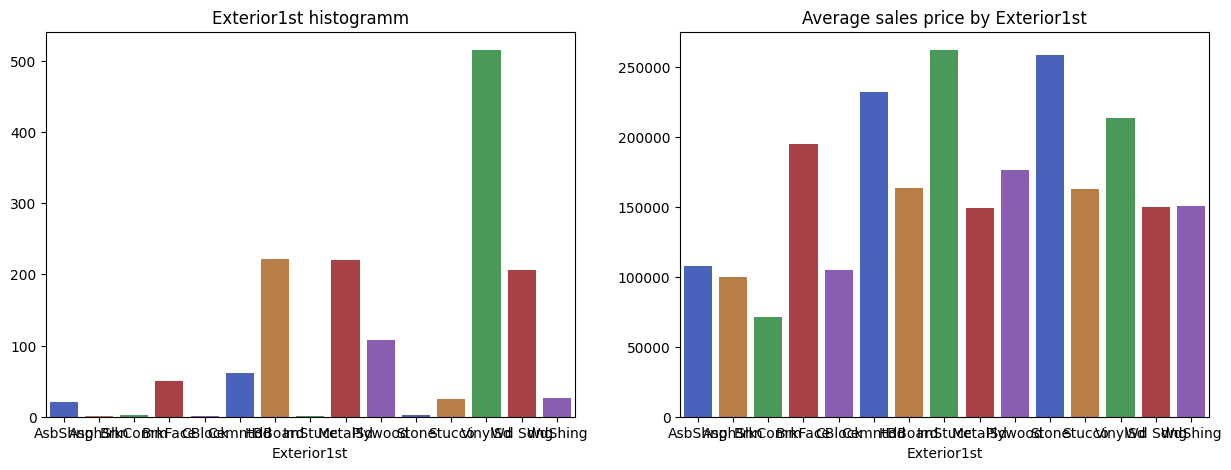

In [292]:
show_distributions_for_cat("Exterior1st")

Exterior2nd

In [298]:
df["Exterior2nd"].isna().sum()

0

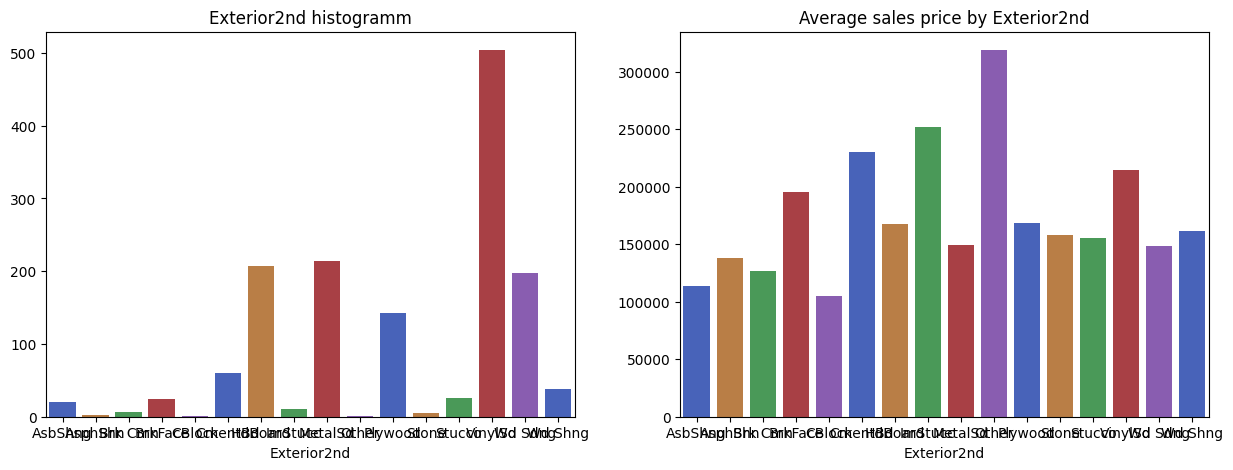

In [299]:
show_distributions_for_cat("Exterior2nd")

MasVnrType

In [306]:
df["MasVnrType"].isna().sum()

0

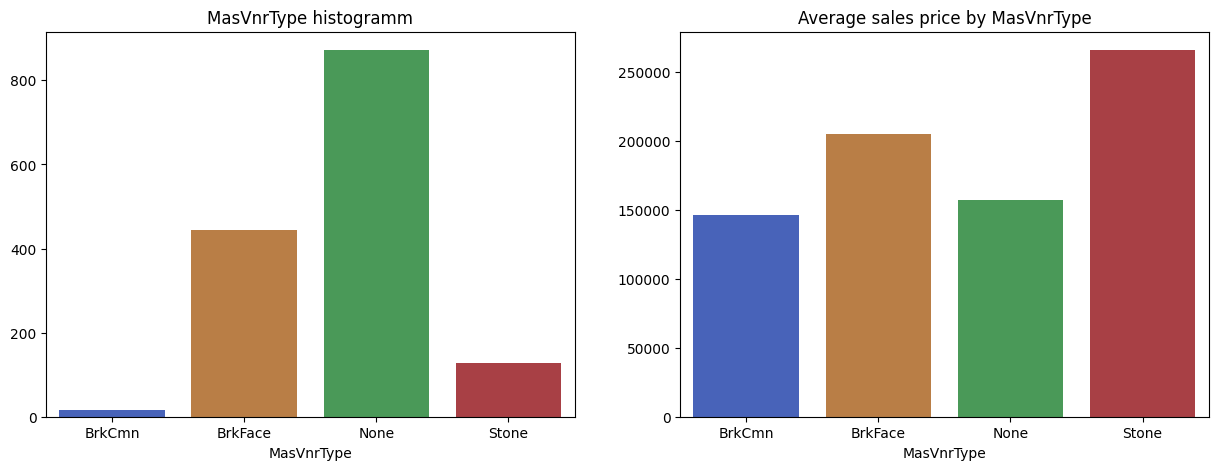

In [307]:
show_distributions_for_cat("MasVnrType")

MasVnrArea

In [308]:
df["MasVnrArea"].isna().sum()

8

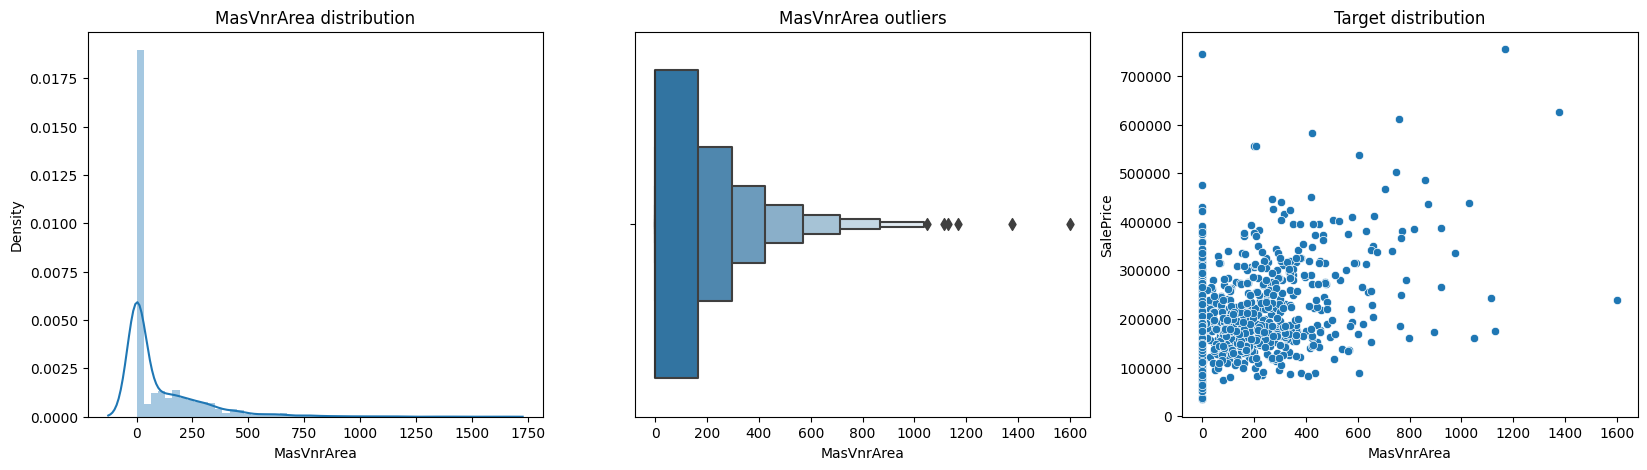

In [309]:
show_distriubutions_for_num('MasVnrArea')

ExterQual

In [336]:
df["ExterQual"].isna().sum()

0

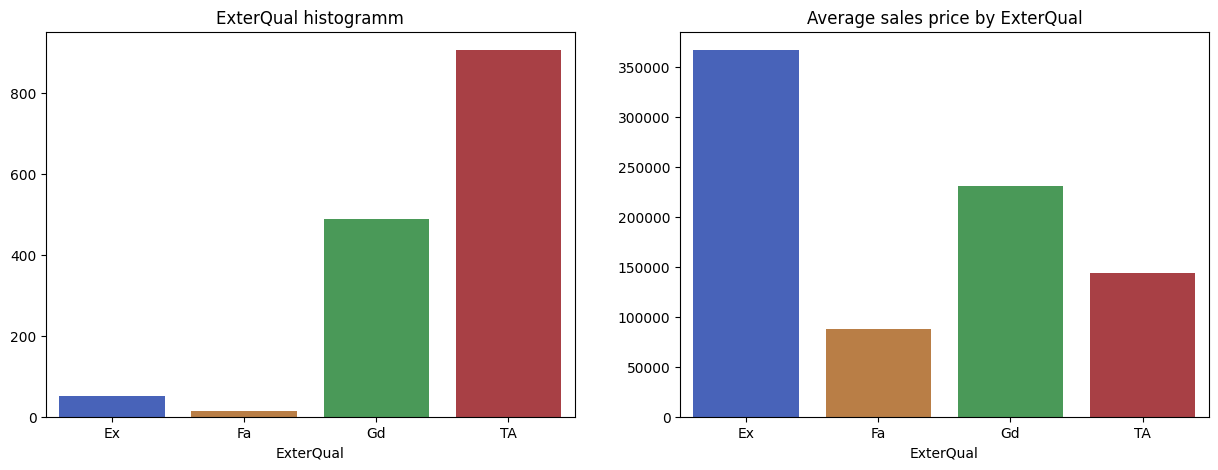

In [337]:
show_distributions_for_cat("ExterQual")

ExterCond

In [339]:
df["ExterCond"].isna().sum()

0

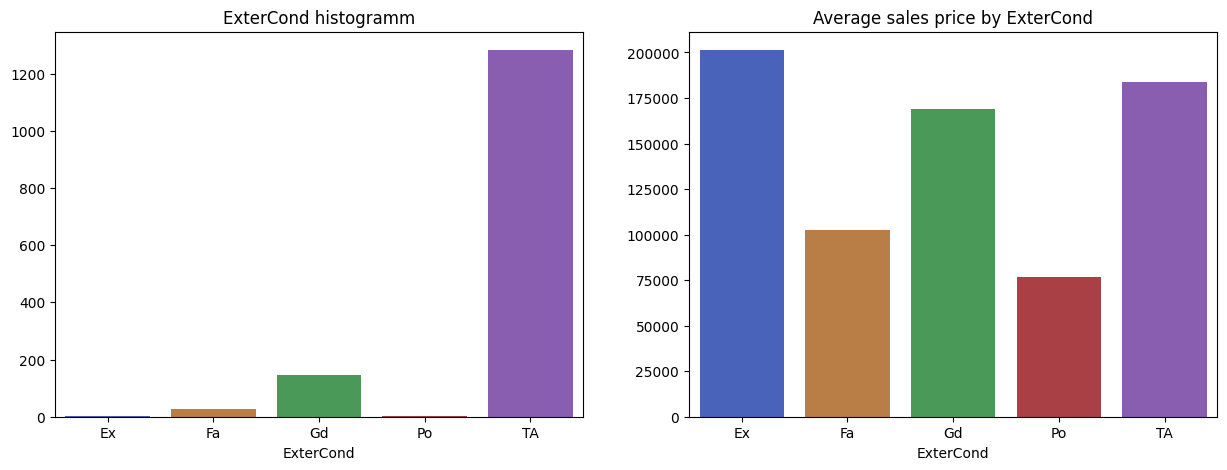

In [340]:
show_distributions_for_cat("ExterCond")

Foundation

In [344]:
df["Foundation"].isna().sum()

0

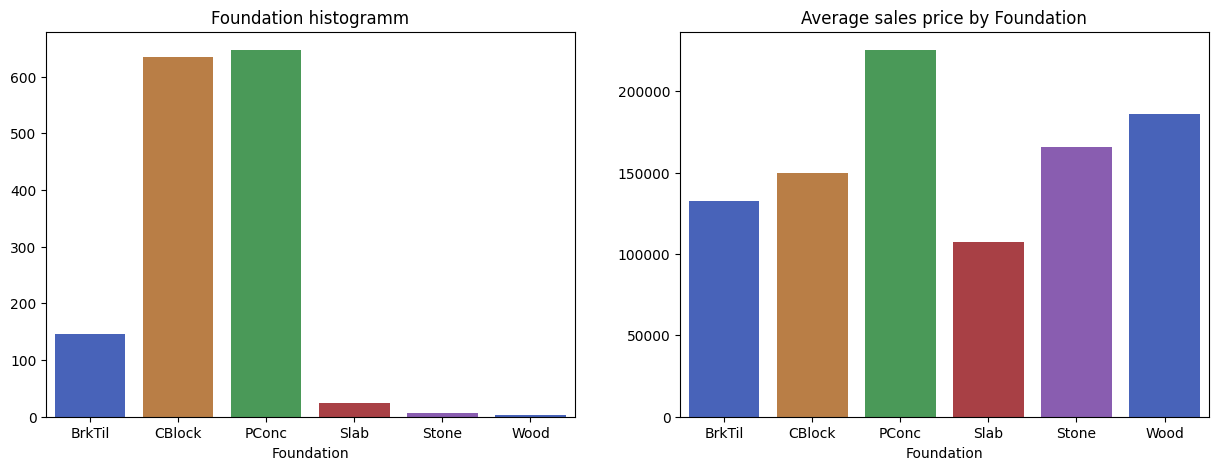

In [345]:
show_distributions_for_cat("Foundation")

BsmtQual

In [347]:
df["BsmtQual"].isna().sum()

37

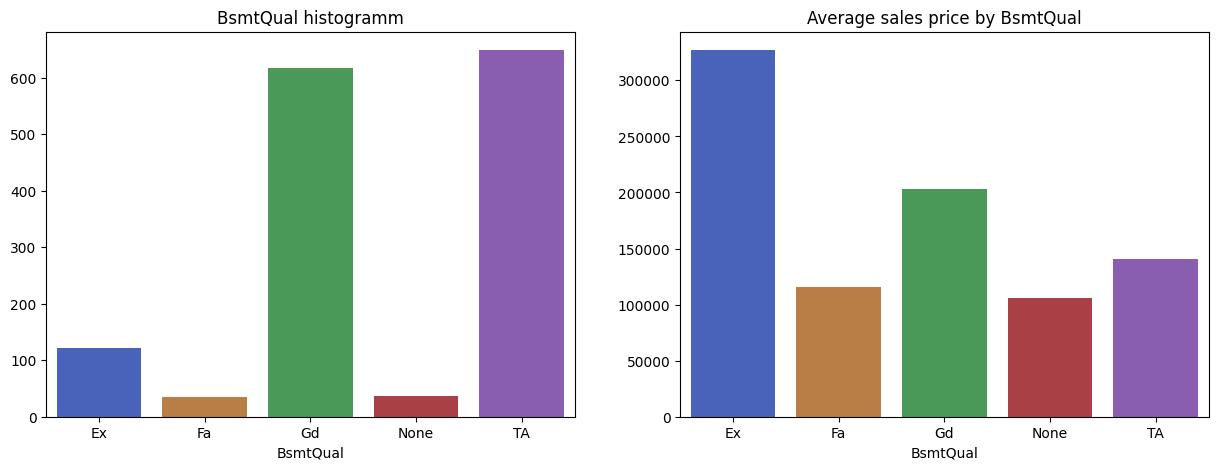

In [350]:
show_distributions_for_cat("BsmtQual")

BsmtCond

In [352]:
df["BsmtCond"].isna().sum()

37

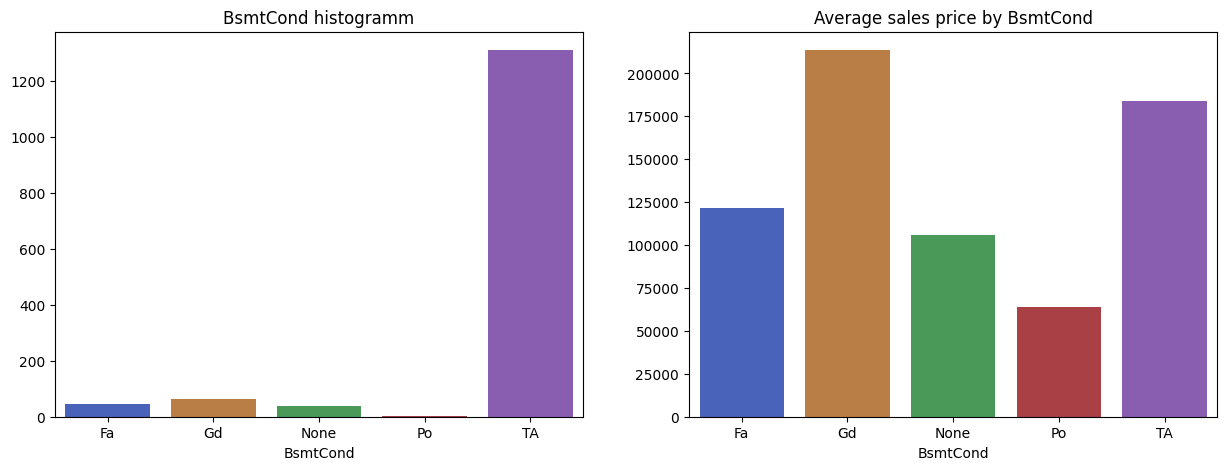

In [355]:
show_distributions_for_cat("BsmtCond")

BsmtExposure

In [357]:
df["BsmtExposure"].isna().sum()

38

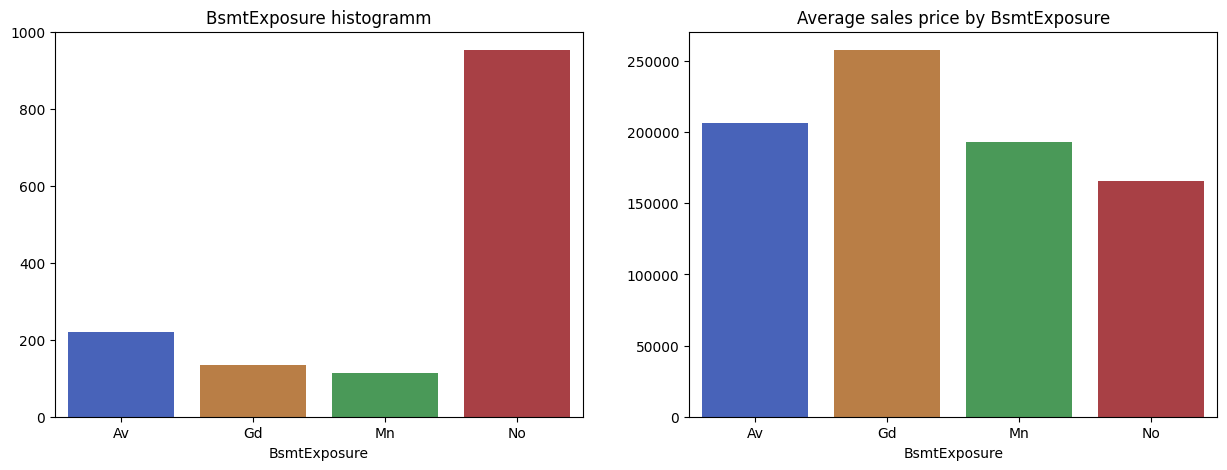

In [358]:
show_distributions_for_cat("BsmtExposure")

BsmtFinType1

In [363]:
df["BsmtFinType1"].isna().sum()


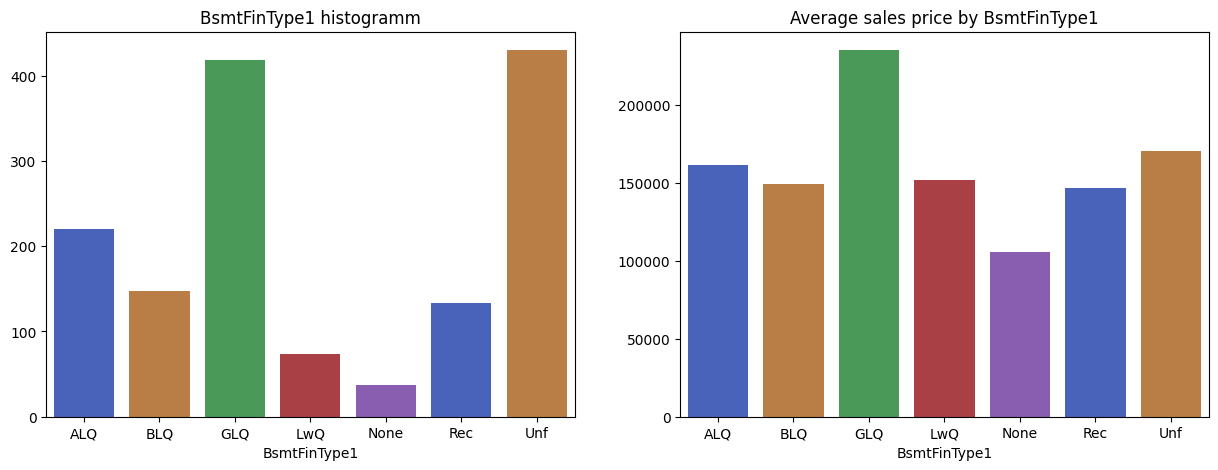

In [364]:
show_distributions_for_cat("BsmtFinType1")

BsmtFinSF1

In [365]:
df["BsmtFinSF1"].isna().sum()

0

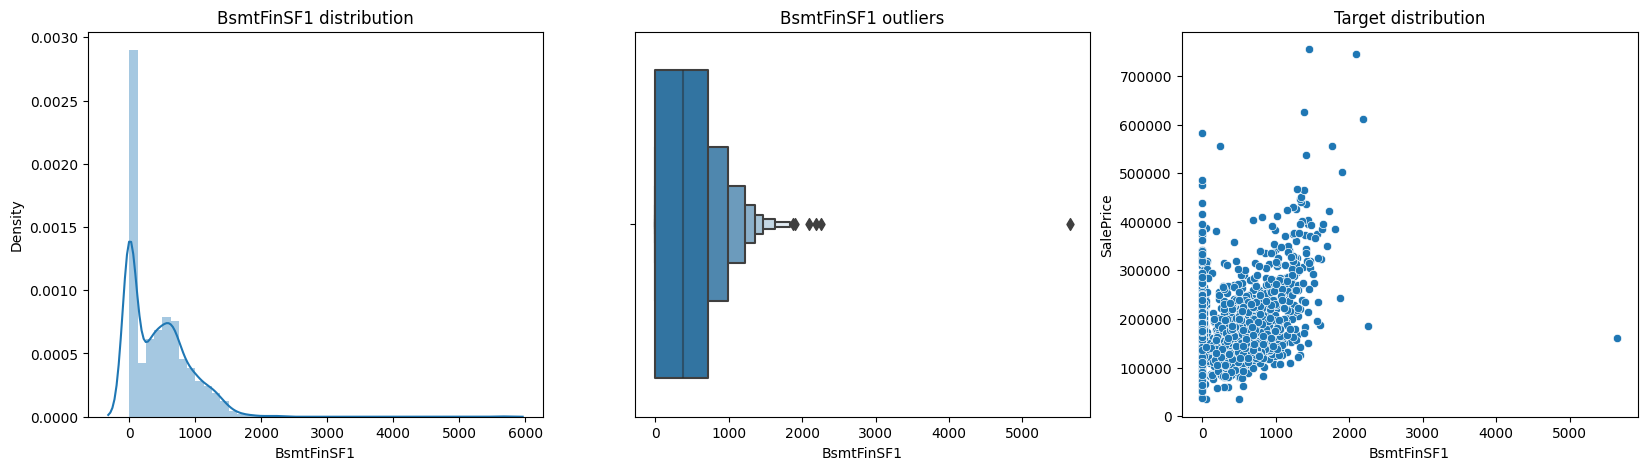

In [366]:
show_distriubutions_for_num('BsmtFinSF1')

BsmtFinType2

In [370]:
df["BsmtFinType2"].isna().sum()

38

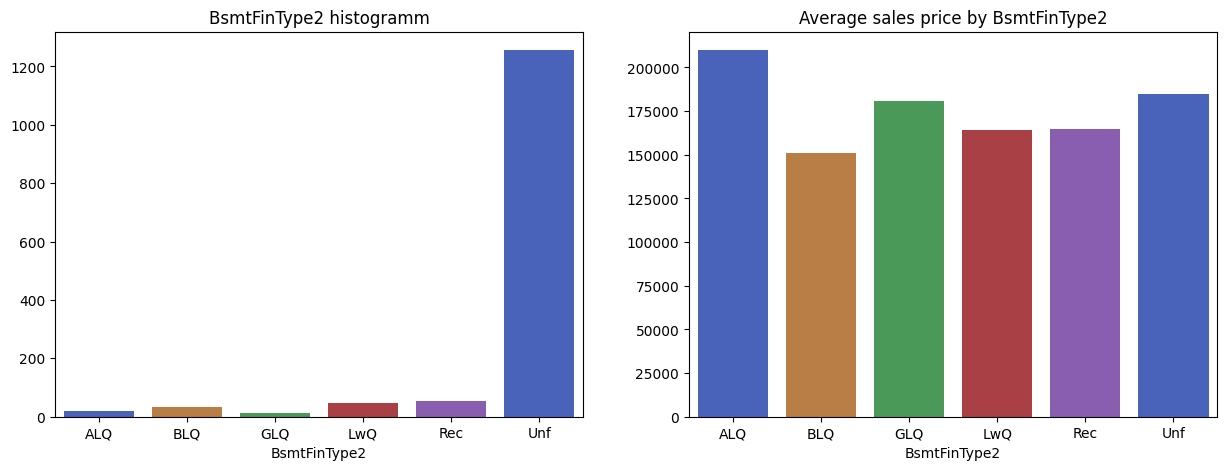

In [371]:
show_distributions_for_cat("BsmtFinType2")

BsmtFinSF2

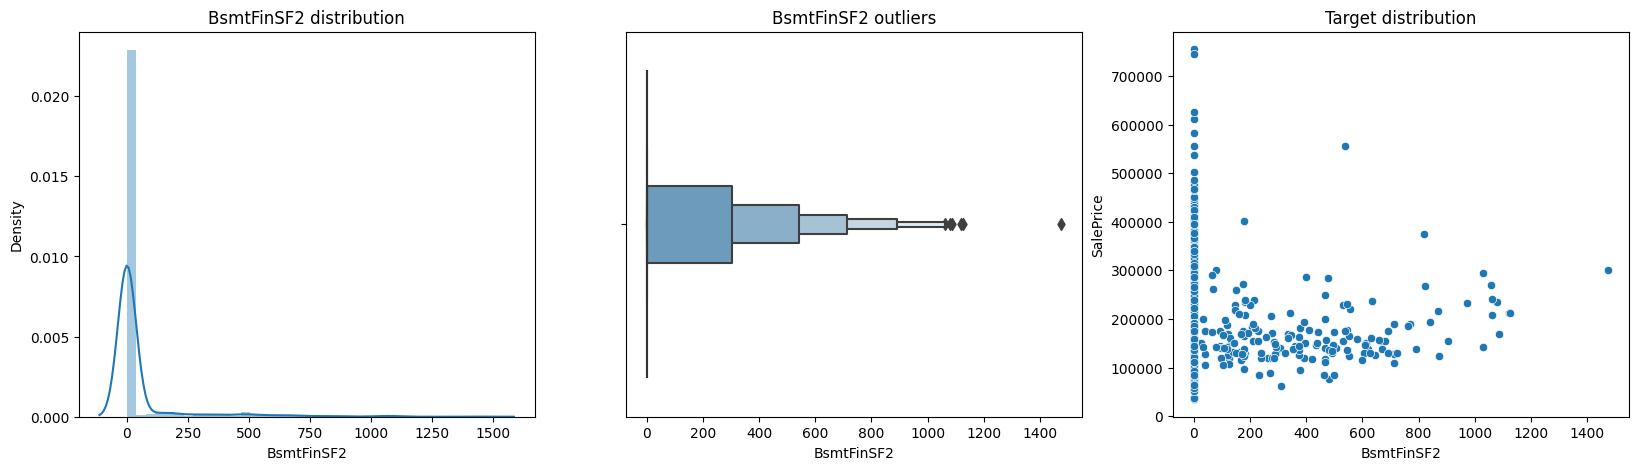

In [375]:
show_distriubutions_for_num('BsmtFinSF2')

BsmtUnfSF

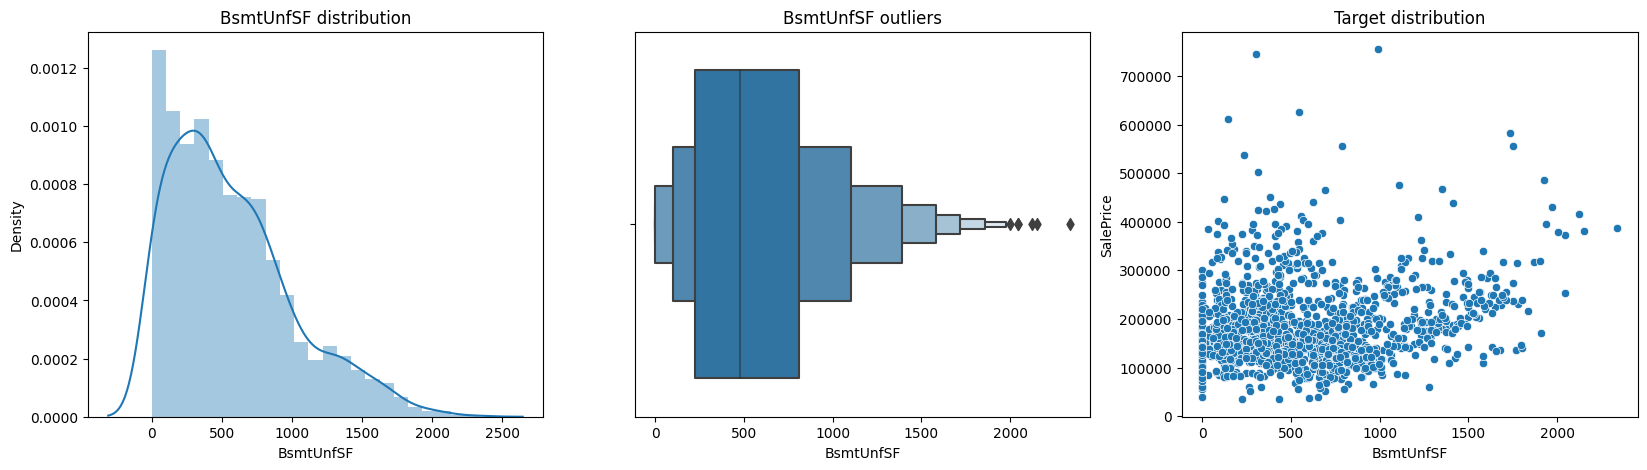

In [377]:
show_distriubutions_for_num('BsmtUnfSF')

TotalBsmtSF

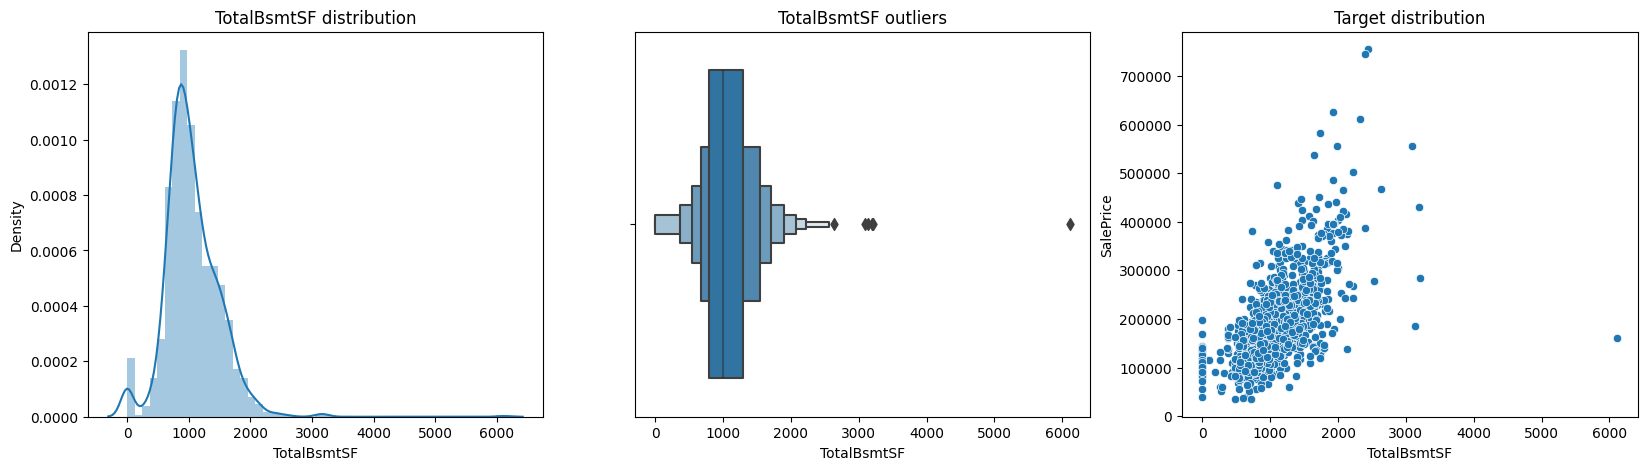

In [379]:
show_distriubutions_for_num('TotalBsmtSF')

Heating

In [382]:
df["Heating"].isna().sum()

0

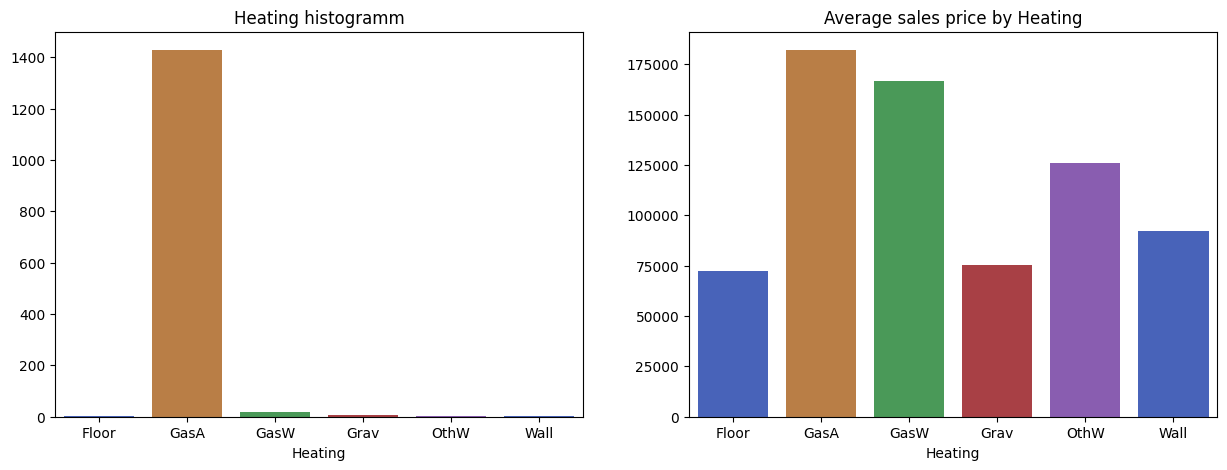

In [383]:
show_distributions_for_cat("Heating")

Will skip Heating as majority of iteams are grouped in one bin

HeatingQC

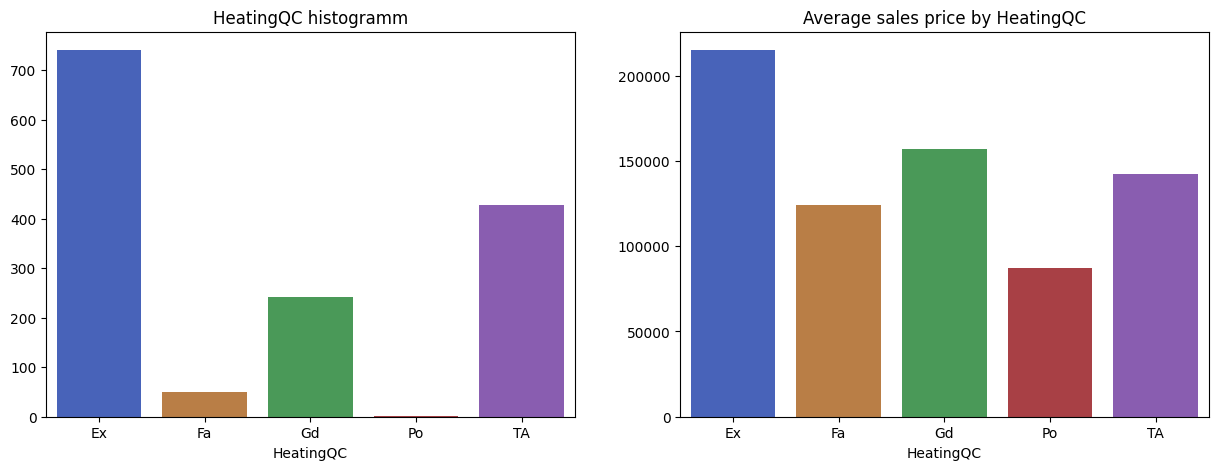

In [384]:
show_distributions_for_cat("HeatingQC")

CentralAir

In [386]:
df["CentralAir"].isna().sum()

0

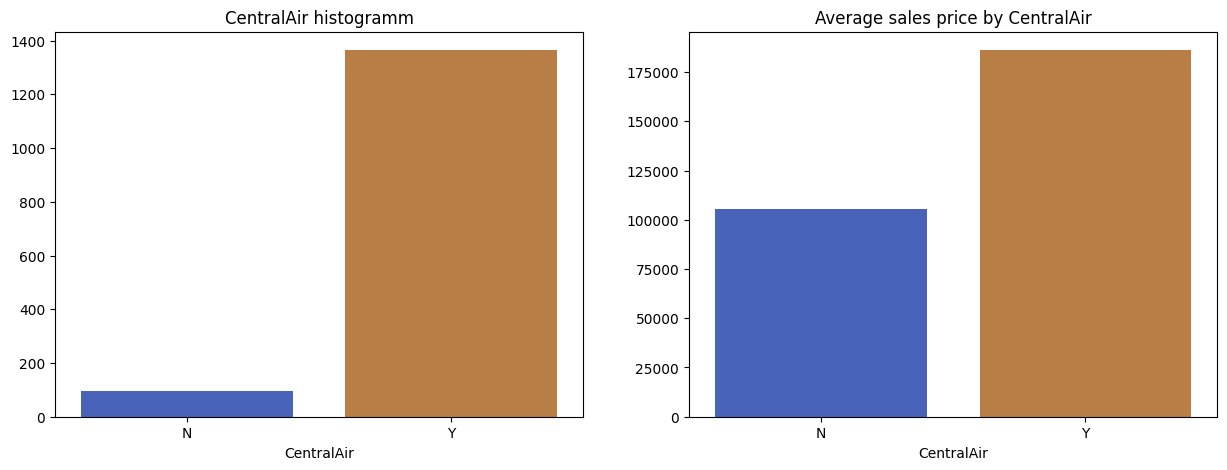

In [387]:
show_distributions_for_cat("CentralAir")

Electrical

In [389]:
df["Electrical"].isna().sum()

1

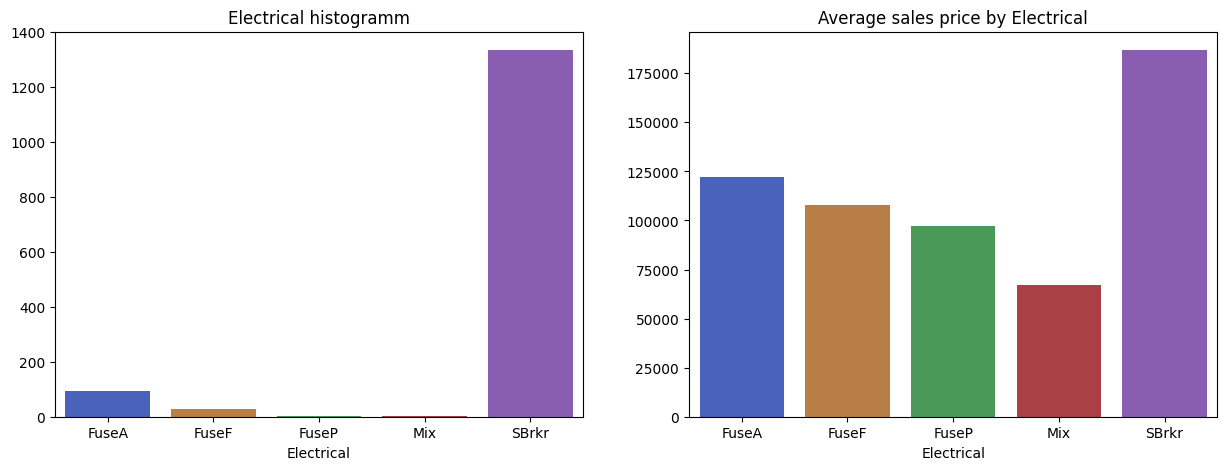

In [390]:
show_distributions_for_cat("Electrical")

1stFlrSF

In [392]:
df["1stFlrSF"].isna().sum()

0

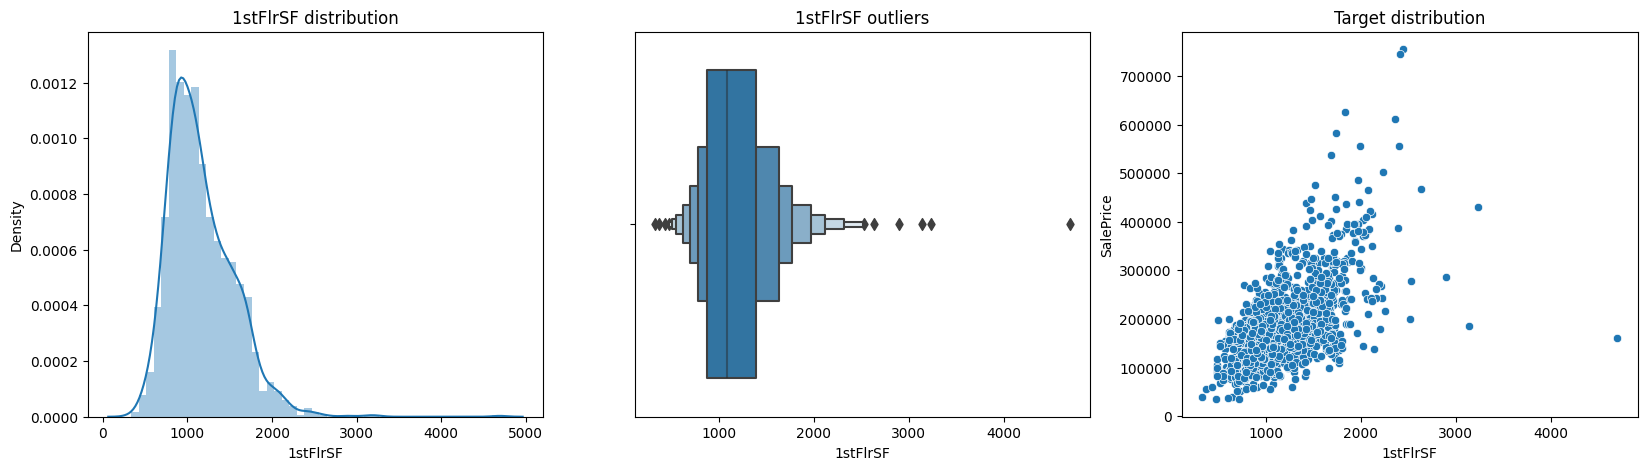

In [393]:
show_distriubutions_for_num('1stFlrSF')

2ndFlrSF

In [395]:
df["2ndFlrSF"].isna().sum()

0

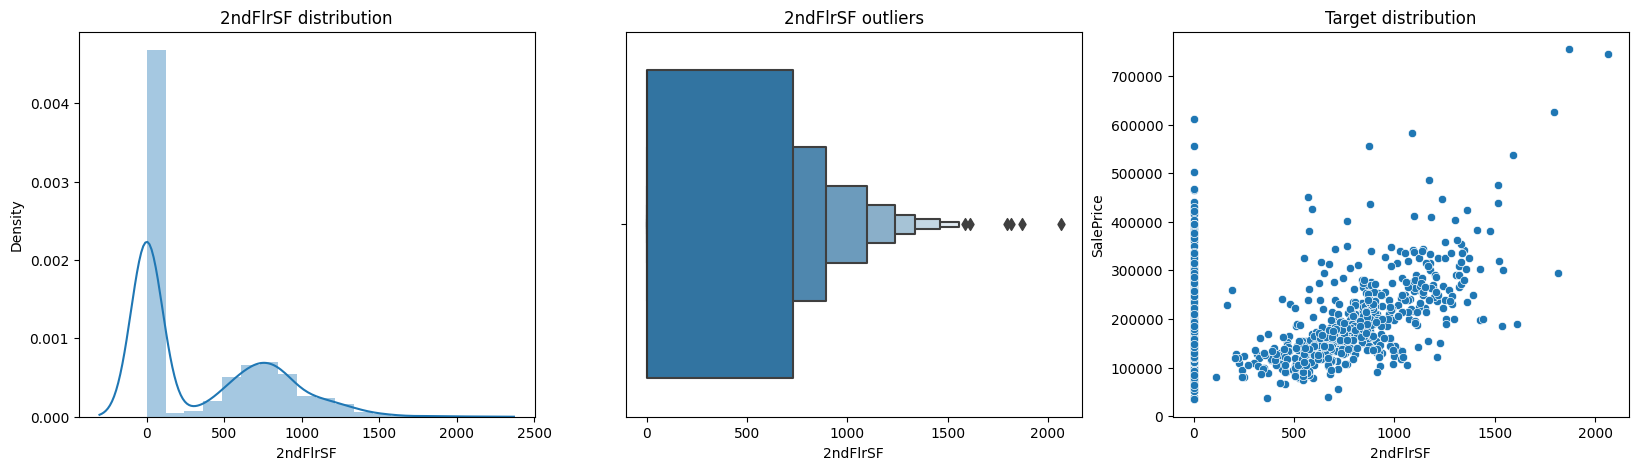

In [396]:
show_distriubutions_for_num('2ndFlrSF')

LowQualFinSF

In [398]:
df["LowQualFinSF"].isna().sum()

0

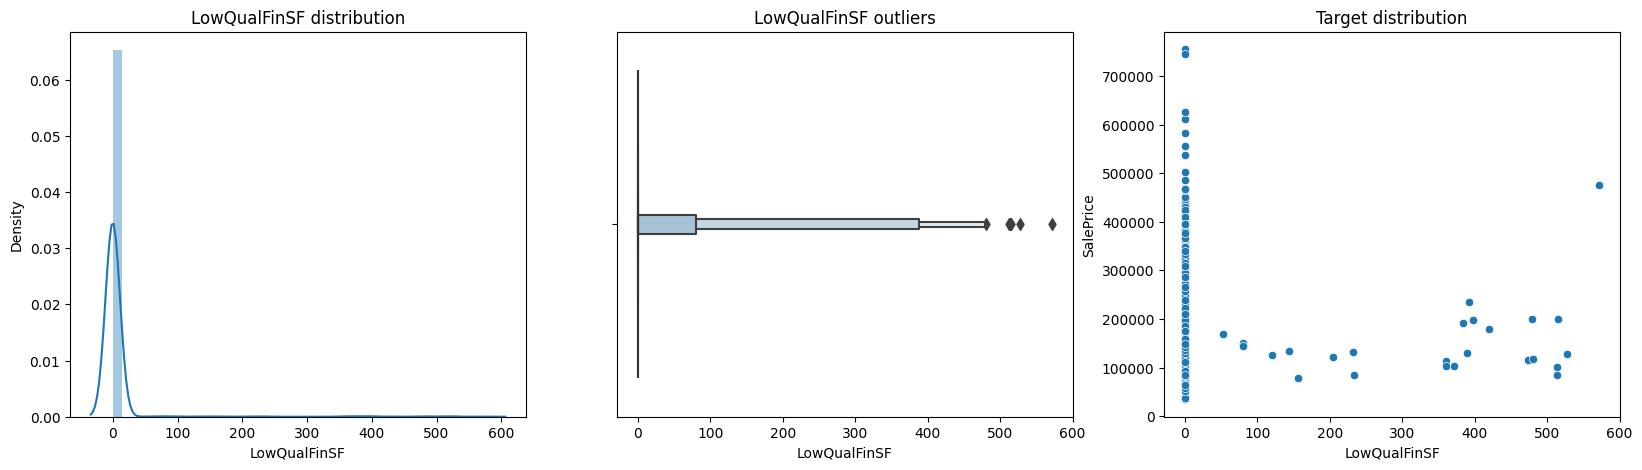

In [399]:
show_distriubutions_for_num('LowQualFinSF')

Noisy feature

GrLivArea

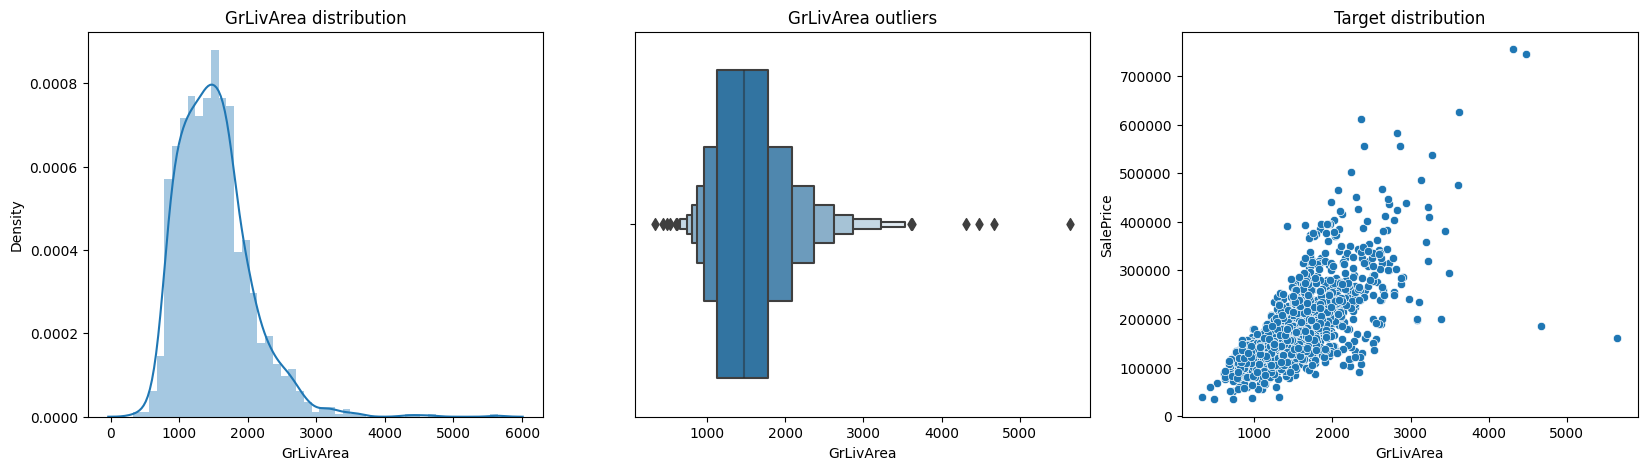

In [400]:
show_distriubutions_for_num('GrLivArea')

BsmtFullBath

In [404]:
df["BsmtFullBath"].isna().sum()

0

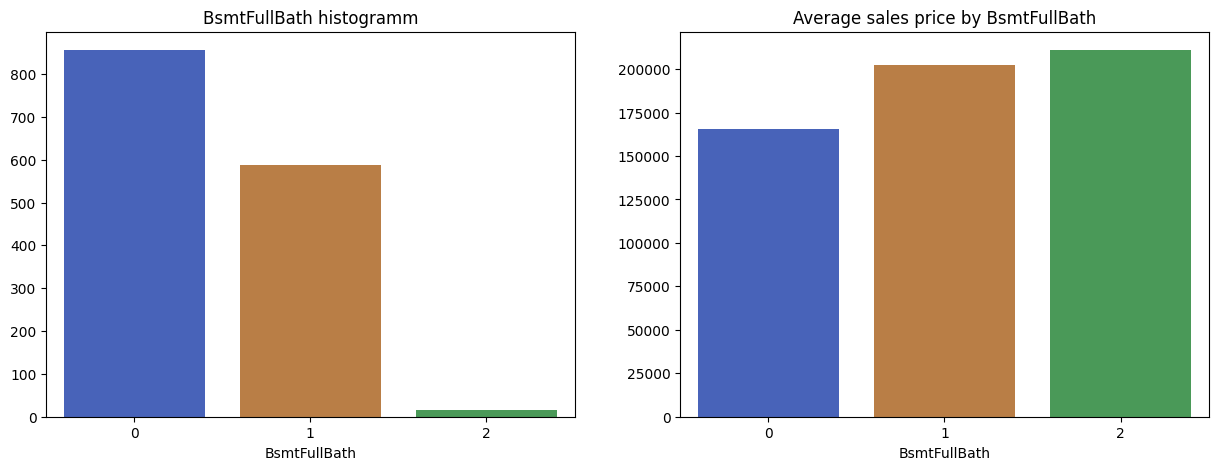

In [410]:
show_distributions_for_cat('BsmtFullBath')

BsmtHalfBath

In [412]:
df["BsmtHalfBath"].isna().sum()

0

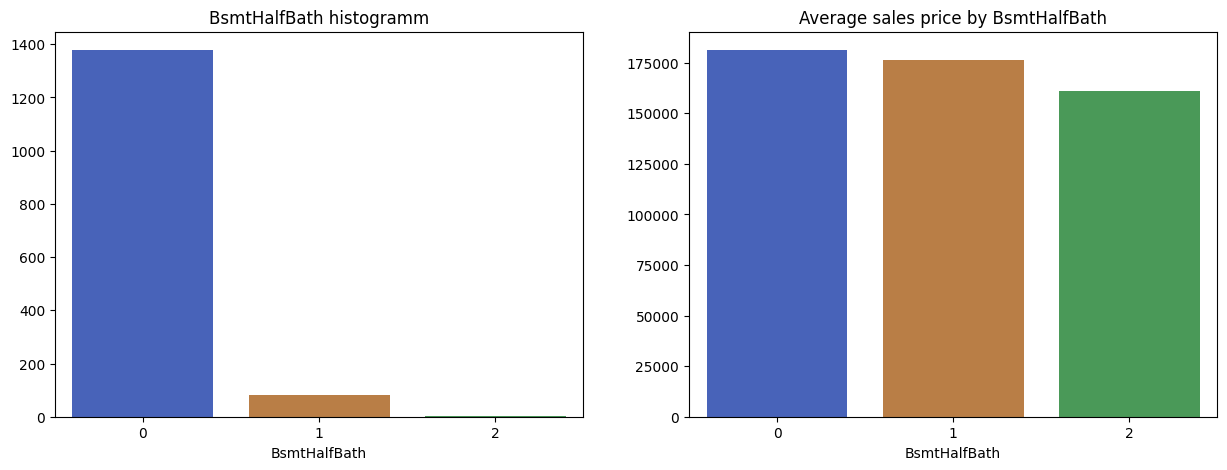

In [413]:
show_distributions_for_cat('BsmtHalfBath')

In [ ]:
Will skip BsmtHalfBath as majority of iteams are grouped in one bin

FullBath

In [414]:
df["FullBath"].isna().sum()

0

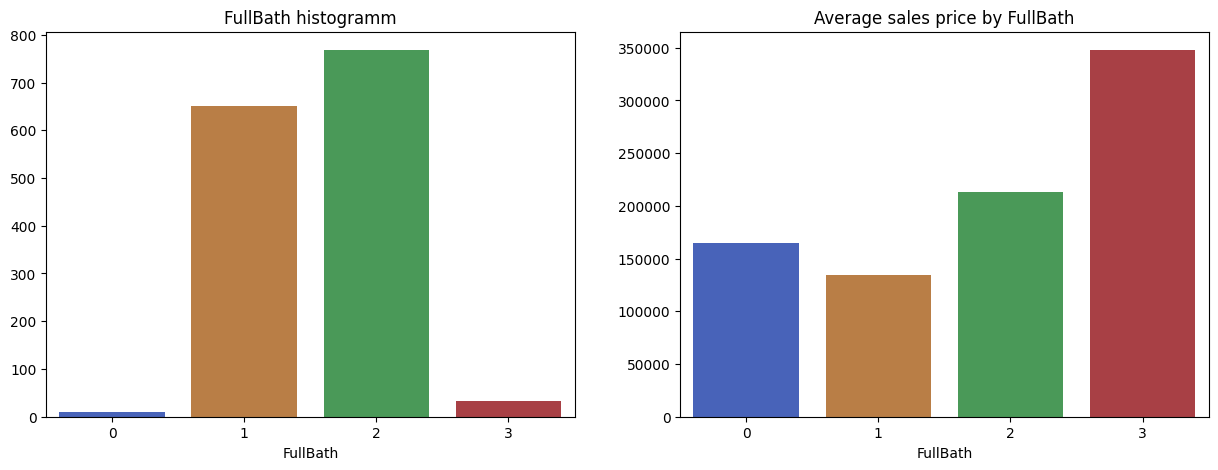

In [415]:
show_distributions_for_cat('FullBath')

HalfBath

In [416]:
df["HalfBath"].isna().sum()

0

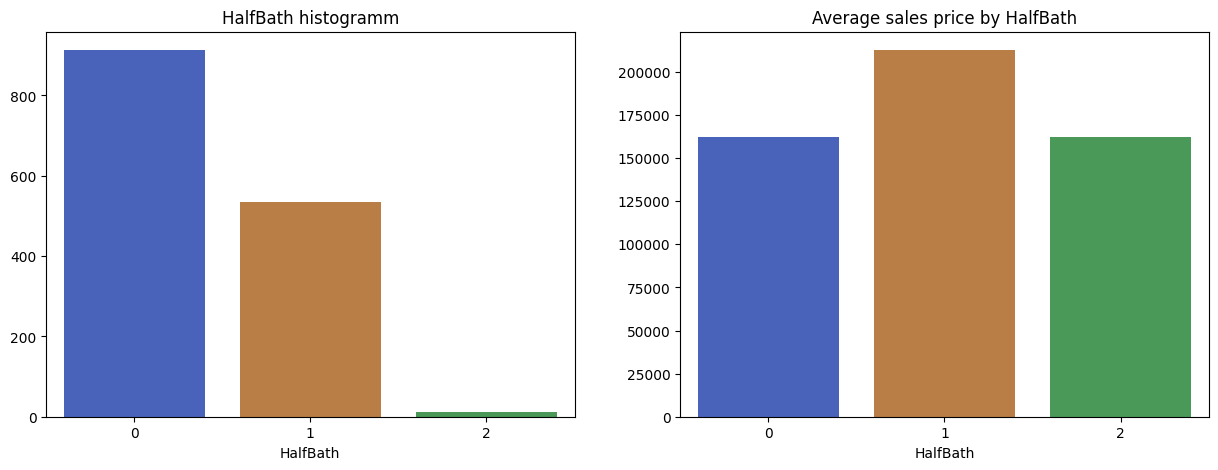

In [417]:
show_distributions_for_cat('HalfBath')

BedroomAbvGr

In [424]:
df["BedroomAbvGr"].isna().sum()

0

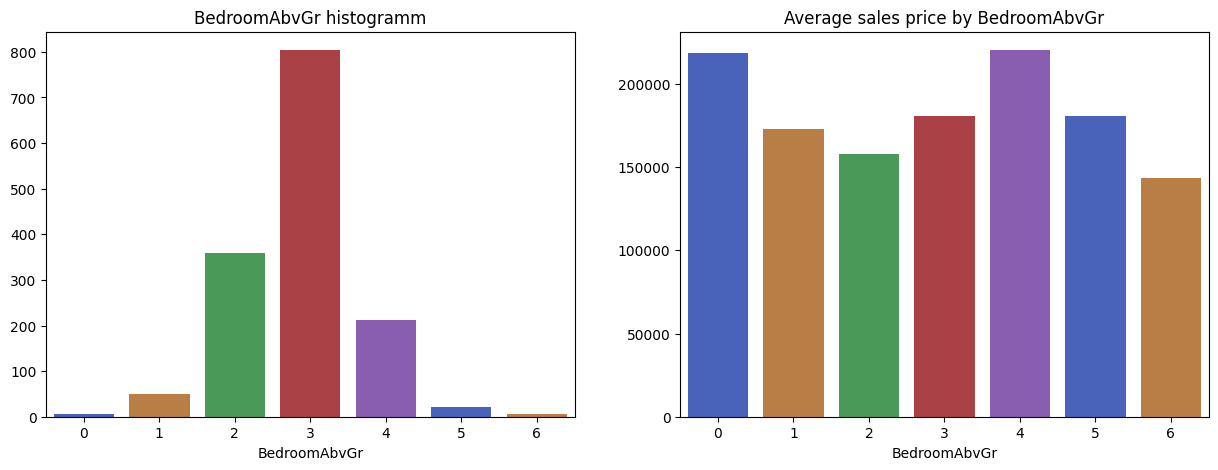

In [427]:
show_distributions_for_cat('BedroomAbvGr')

Join 0 and 8 to one category due to little data

Kitchen

In [22]:
df["KitchenAbvGr"].isna().sum()

0

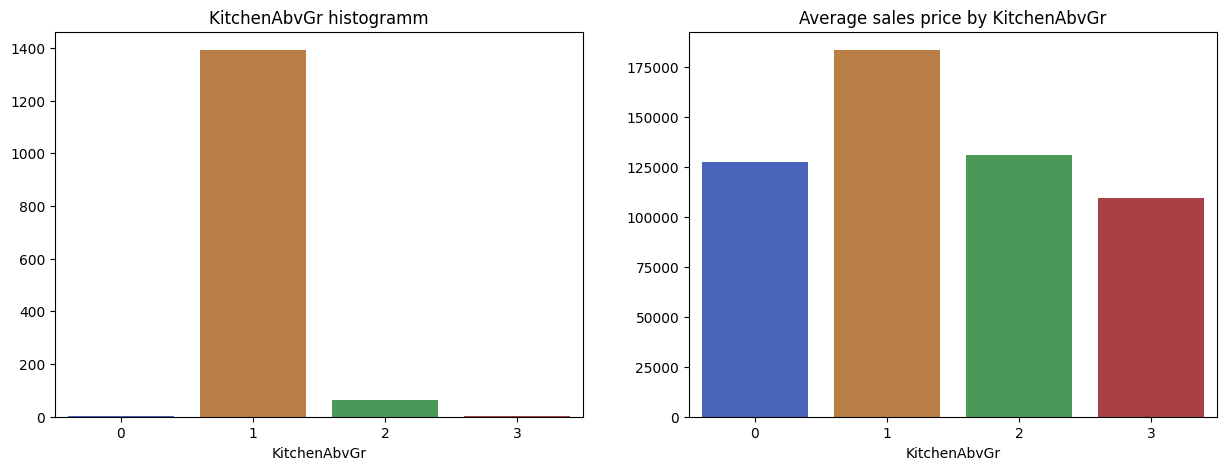

In [23]:
show_distributions_for_cat('KitchenAbvGr')

Will skip KitcheAbobeGrWill skip KitcheAbobeGr as majority of iteams are grouped in one bin as majority of iteams are grouped in one bin

KitchenQual

In [24]:
df["KitchenQual"].isna().sum()

0

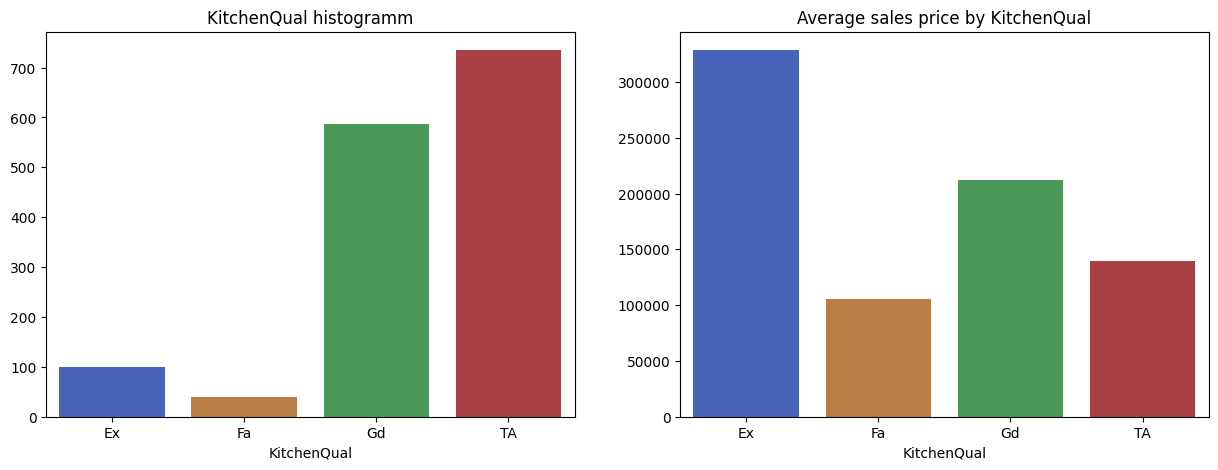

In [25]:
show_distributions_for_cat('KitchenQual')

TotRmsAbvGrd

In [27]:
df["TotRmsAbvGrd"].isna().sum()

0

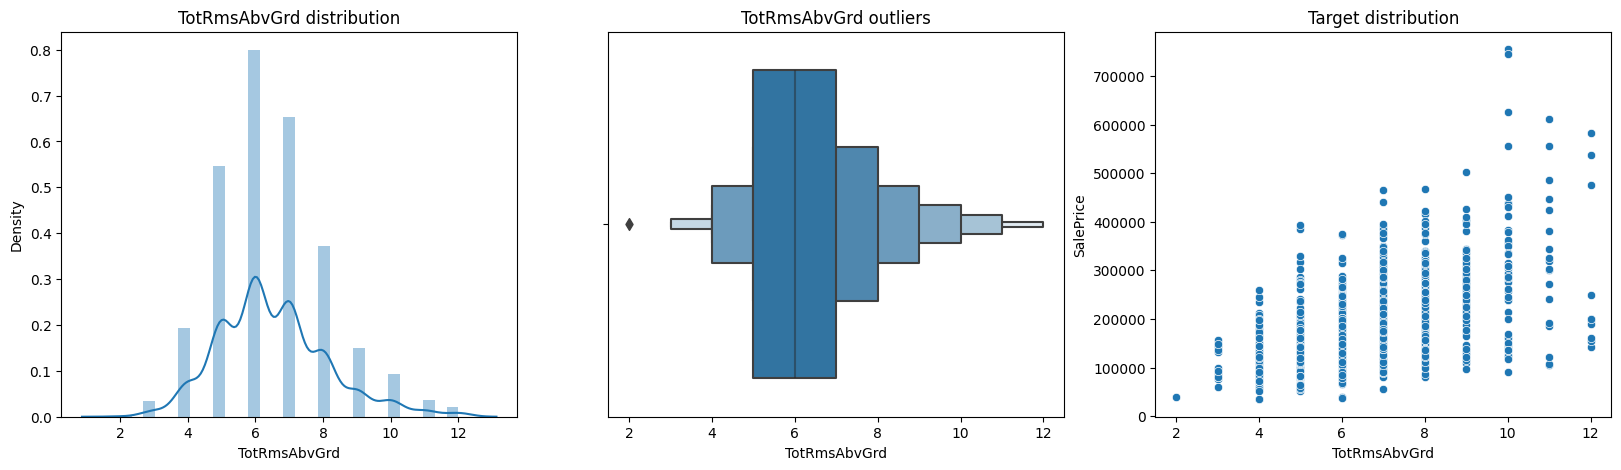

In [31]:
show_distriubutions_for_num('TotRmsAbvGrd')

OpenPorchSF

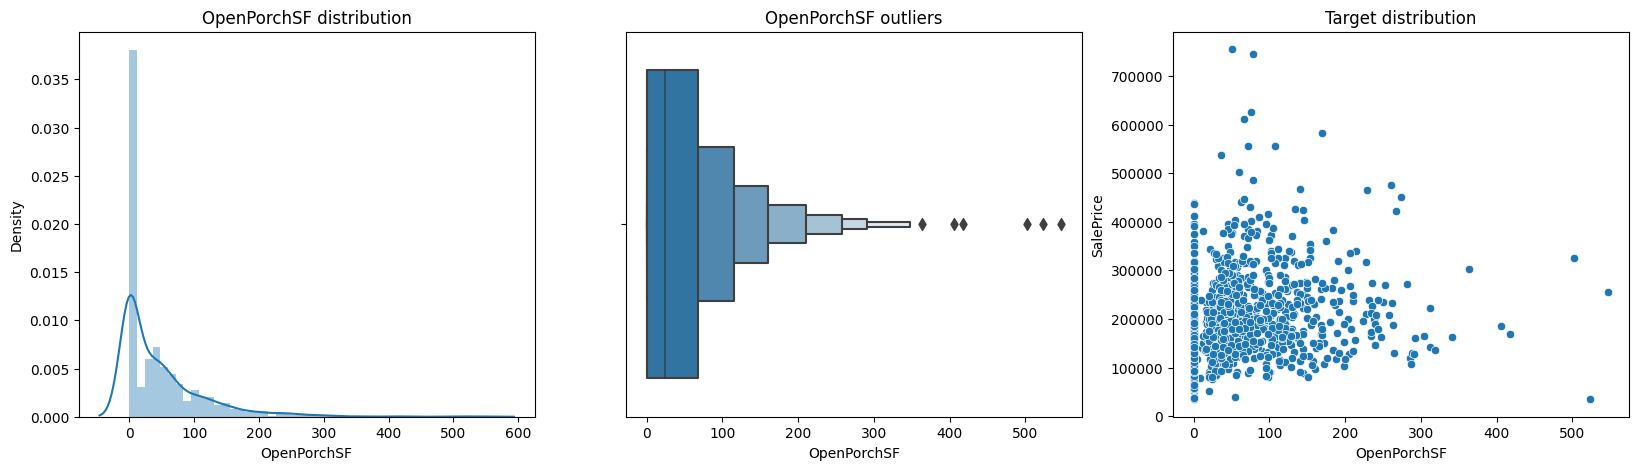

In [74]:
show_distriubutions_for_num('OpenPorchSF')

Delete row with 14 rum_num as inconsistent sample

Functional

In [33]:
df["Functional"].isna().sum()

0

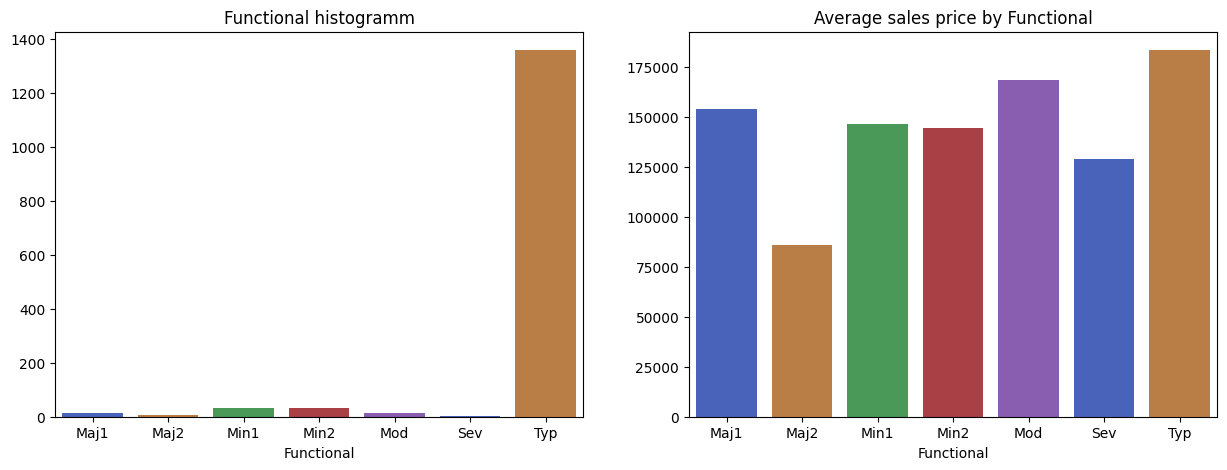

In [35]:
show_distributions_for_cat('Functional')

Will skip Functional as majority of iteams are grouped in one bin

Fireplaces

In [36]:
df["Fireplaces"].isna().sum()

0

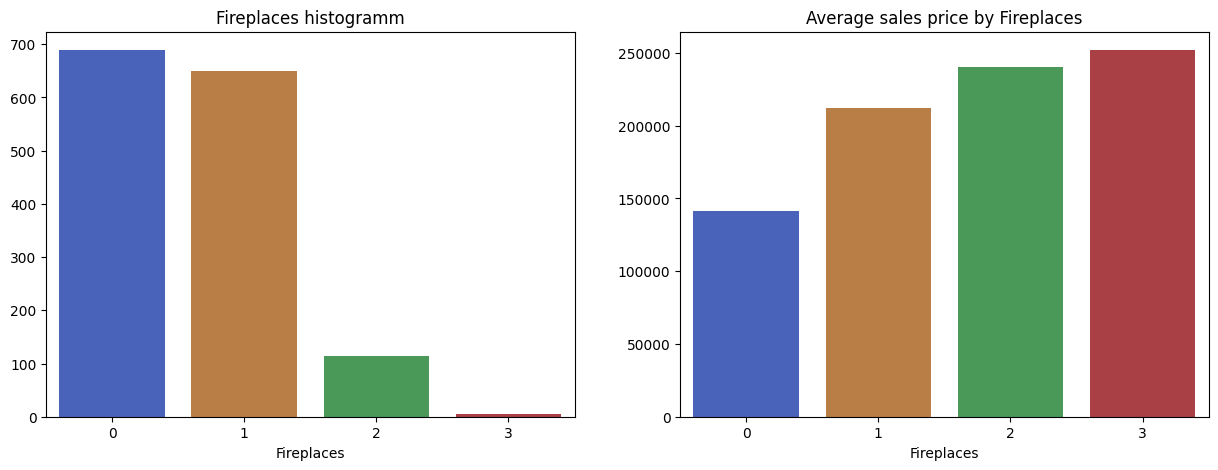

In [37]:
show_distributions_for_cat('Fireplaces')

FireplaceQu

In [39]:
df["FireplaceQu"].isna().sum()

689

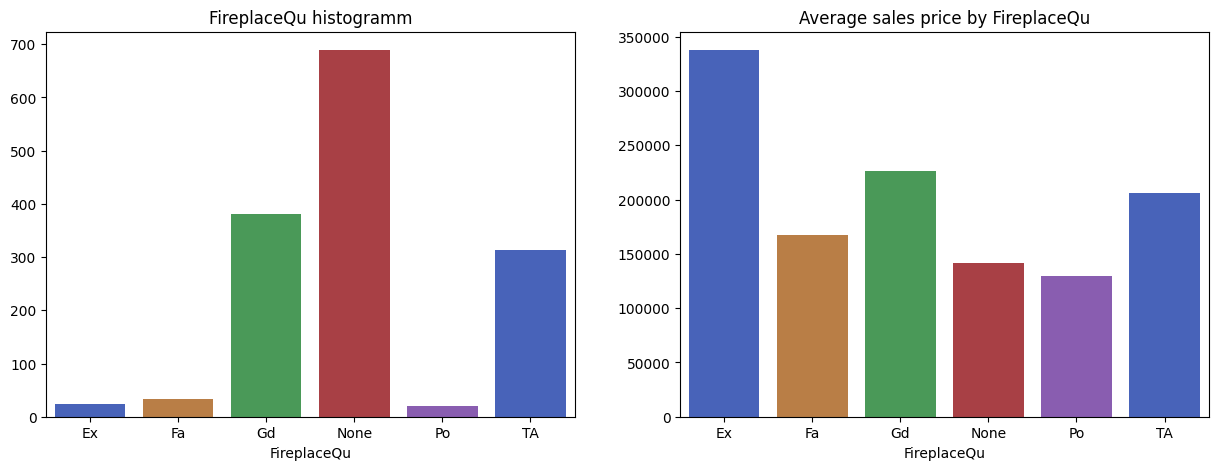

In [42]:
show_distributions_for_cat('FireplaceQu')

GarageType

In [44]:
df["GarageType"].isna().sum()

80

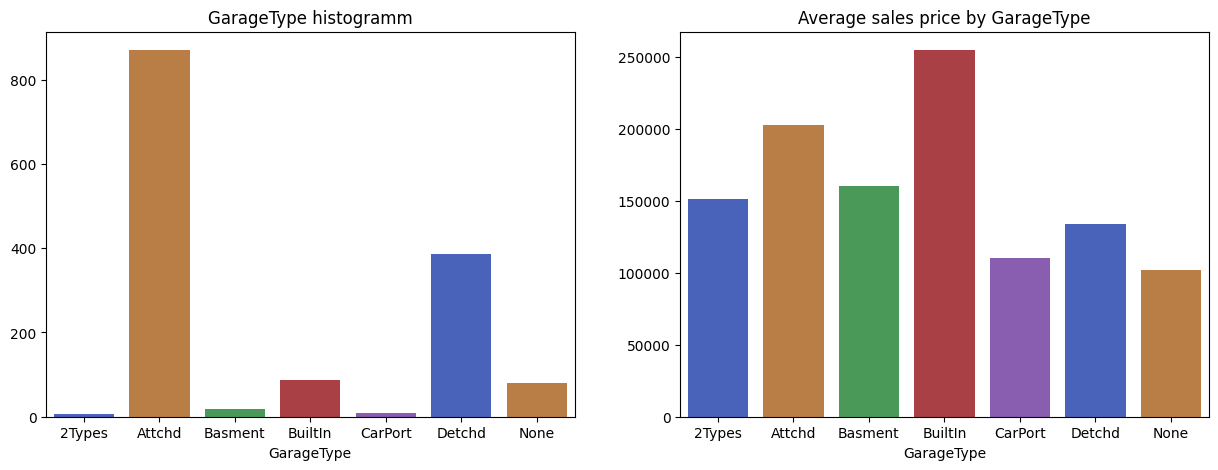

In [48]:
show_distributions_for_cat('GarageType')

GarageFinish

In [49]:
df["GarageFinish"].isna().sum()

80

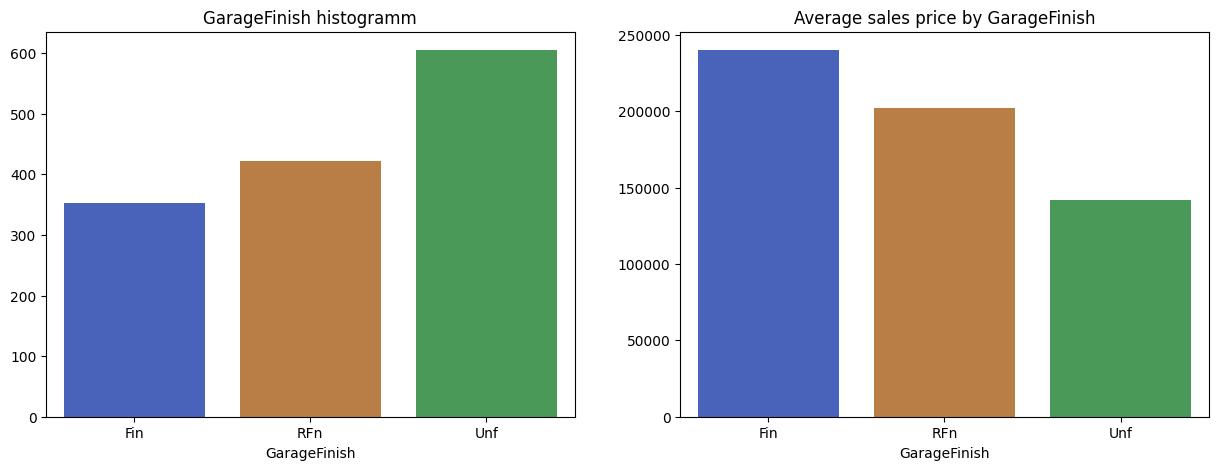

In [50]:
show_distributions_for_cat('GarageFinish')

GarageCars

In [52]:
df["GarageCars"].isna().sum()

0

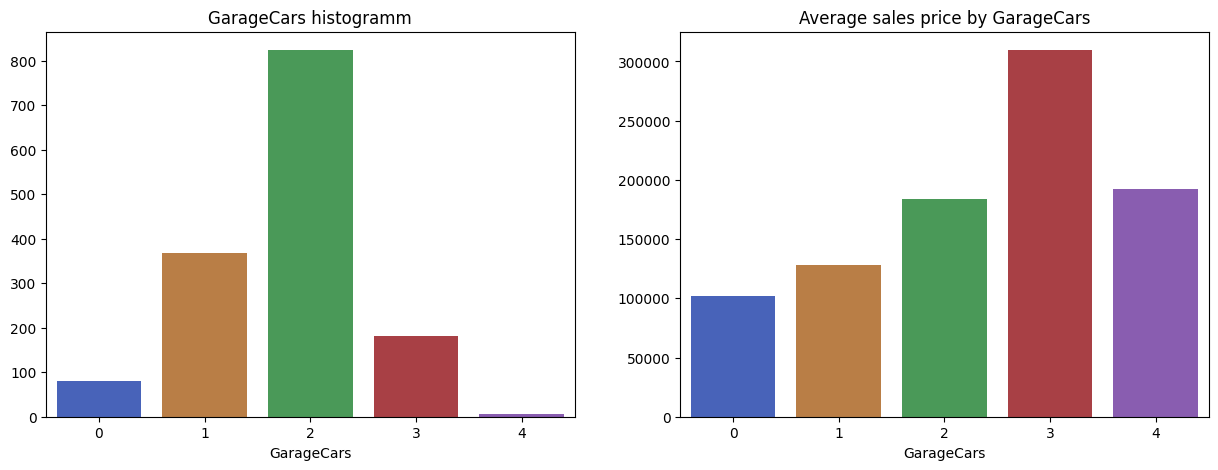

In [53]:
show_distributions_for_cat('GarageCars')

GarageArea

In [54]:
df["GarageArea"].isna().sum()

0

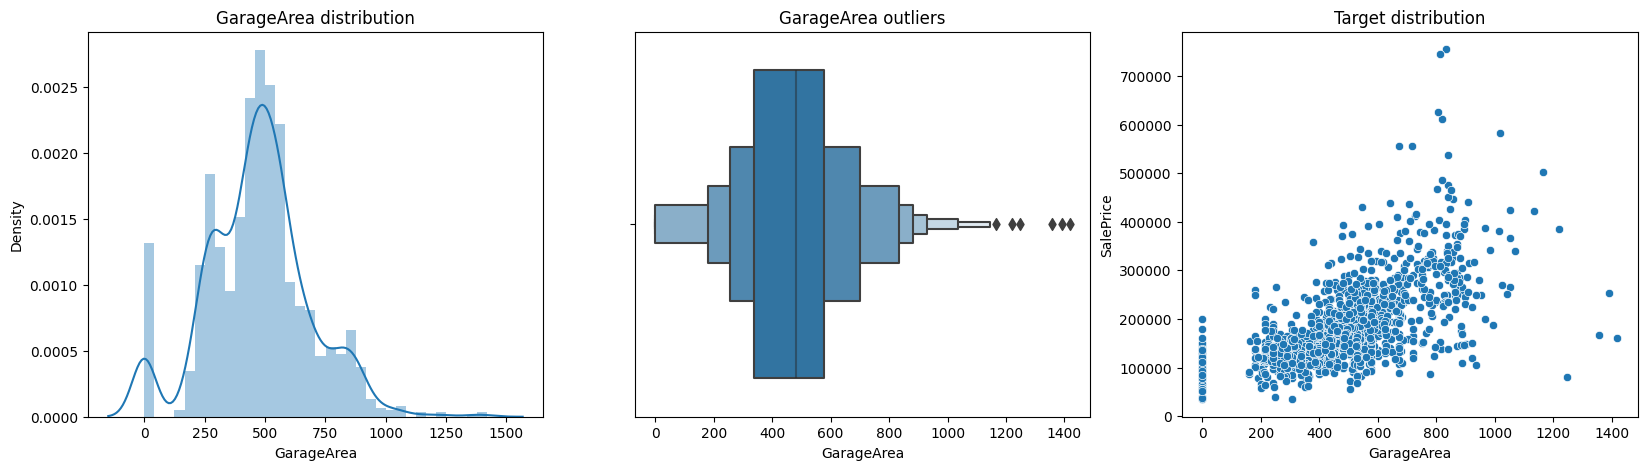

In [55]:
show_distriubutions_for_num('GarageArea')

GarageQual

In [57]:
df["GarageQual"].isna().sum()

80

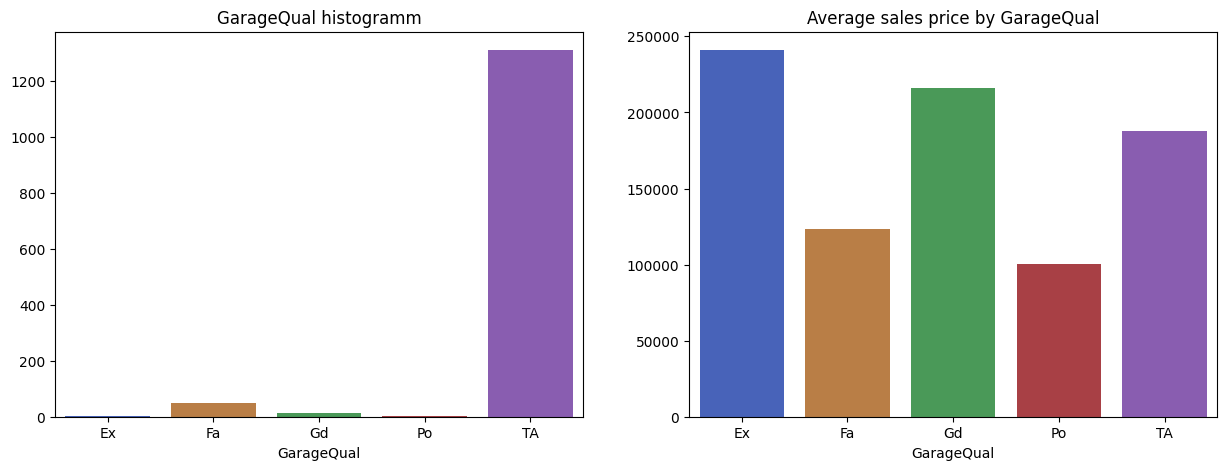

In [58]:
show_distributions_for_cat('GarageQual')

GarageCond

In [62]:
df["GarageCond"].isna().sum()

80

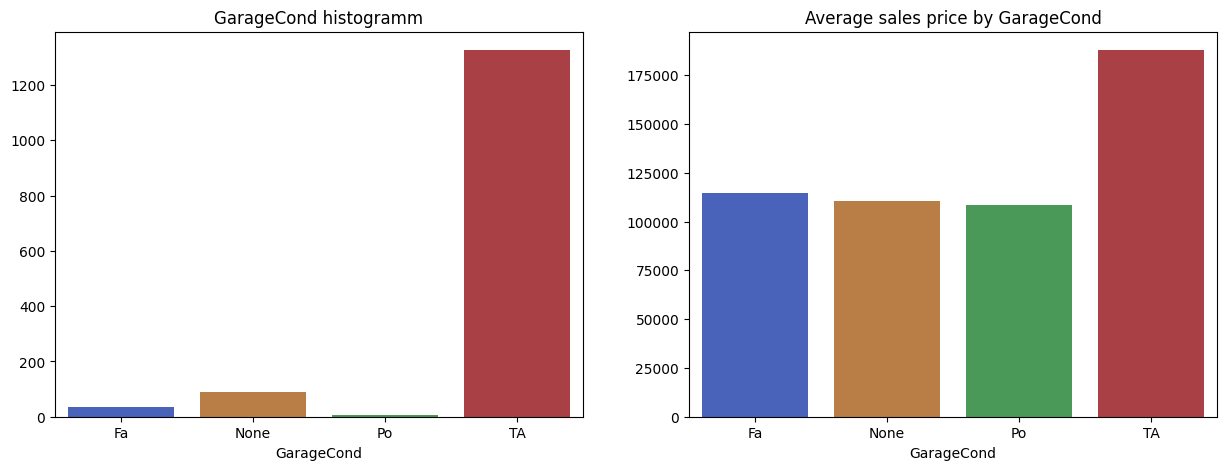

In [65]:
show_distributions_for_cat('GarageCond')

PavedDrive

In [67]:
df["PavedDrive"].isna().sum()

0

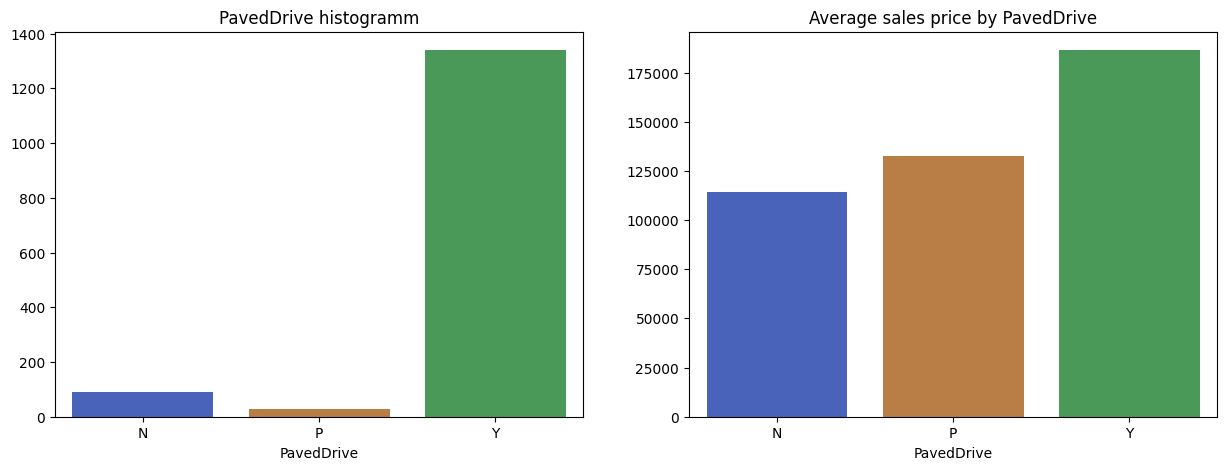

In [72]:
show_distributions_for_cat('PavedDrive')

WoodDeckSF

In [69]:
df["WoodDeckSF"].isna().sum()

0

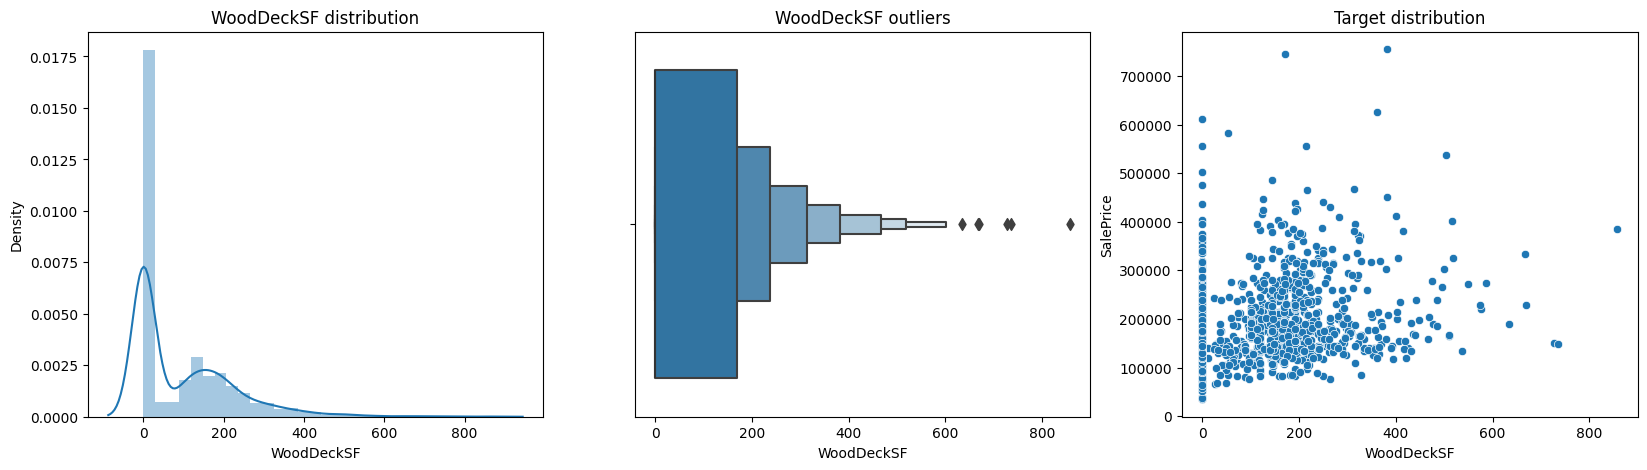

In [73]:
show_distriubutions_for_num('WoodDeckSF')

EnclosedPorch

In [75]:
df["EnclosedPorch"].isna().sum()

0

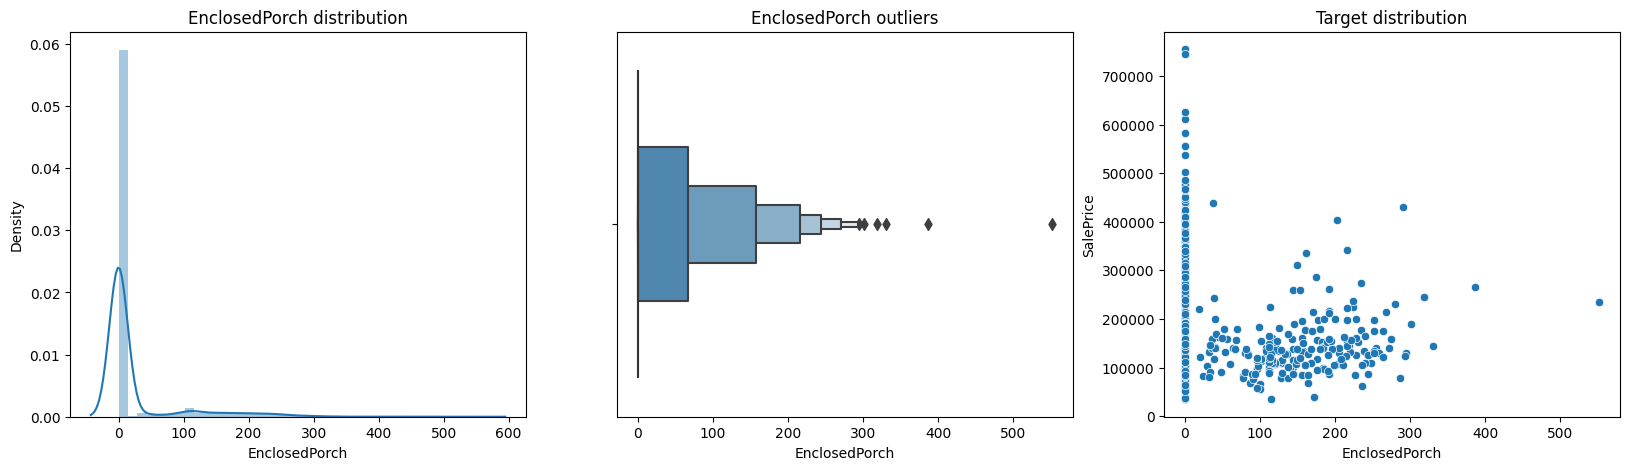

In [76]:
show_distriubutions_for_num('EnclosedPorch')

3SsnPorch

In [77]:
df["3SsnPorch"].isna().sum()

0

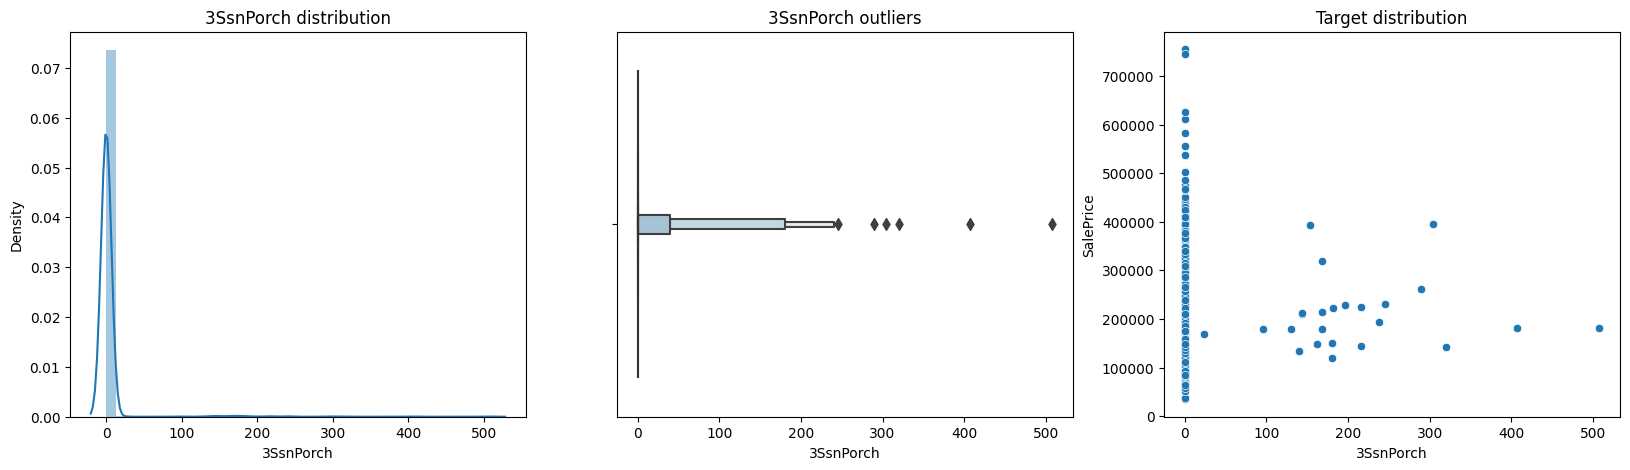

In [80]:
show_distriubutions_for_num('3SsnPorch')

Messy variable

ScreenPorch

In [81]:
df["ScreenPorch"].isna().sum()

0

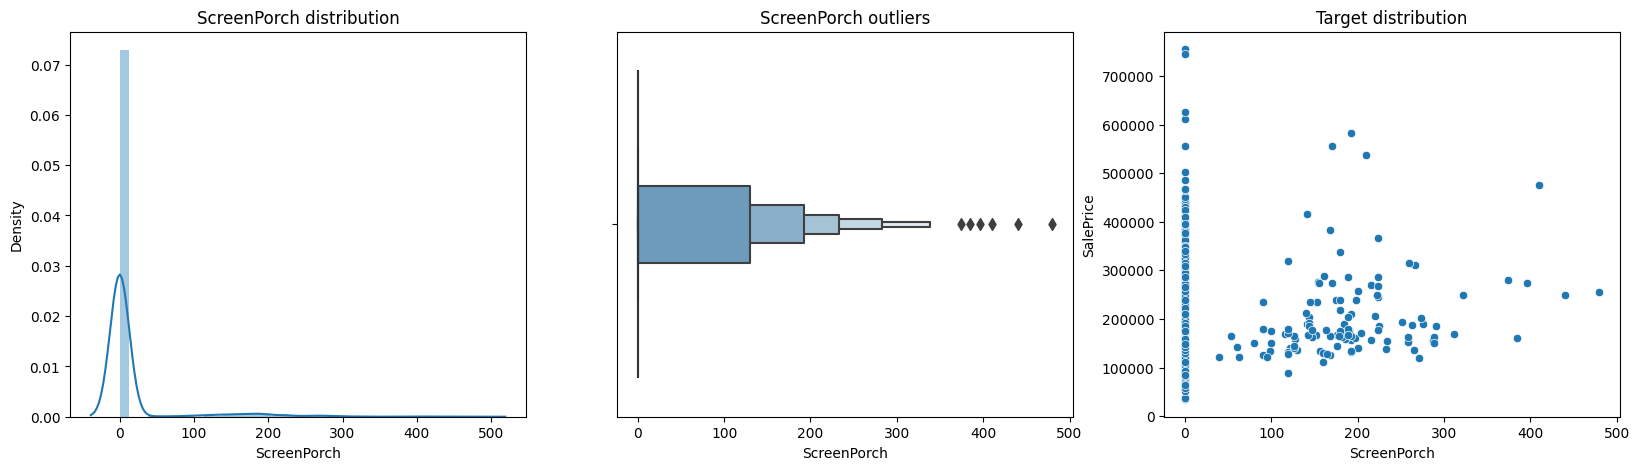

In [82]:
show_distriubutions_for_num('ScreenPorch')

PoolArea

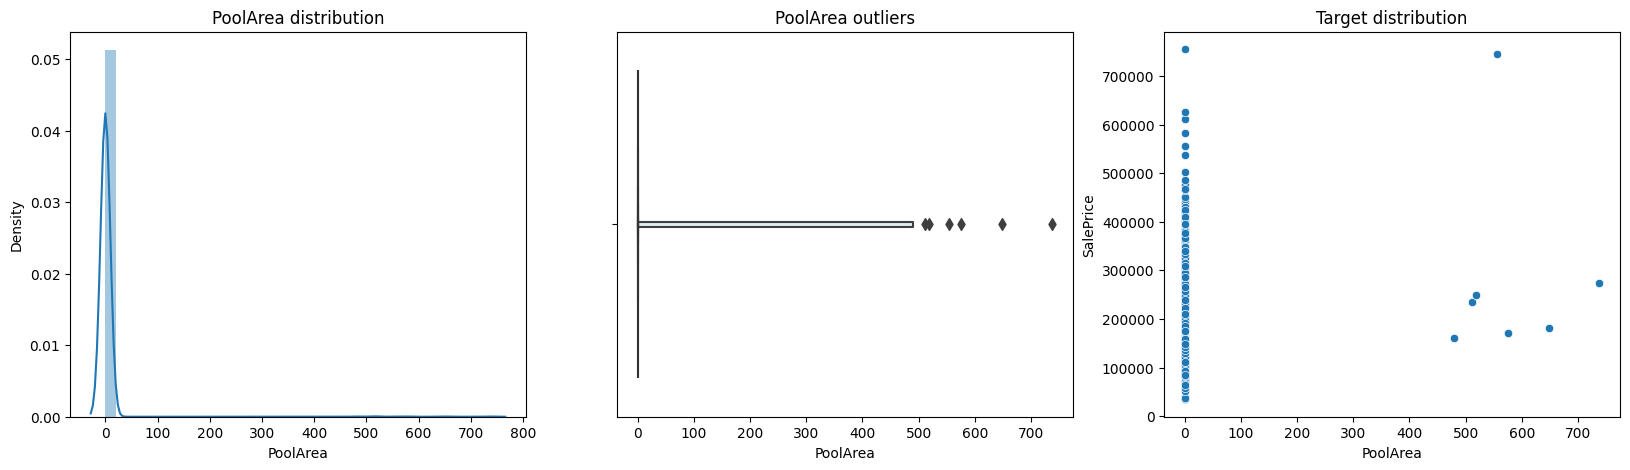

In [84]:
show_distriubutions_for_num('PoolArea')

Messy variable

PoolQC

In [85]:
df["PoolQC"].isna().sum()

1452

Almost none variable

Fence

In [87]:
df["Fence"].isna().sum()

1178

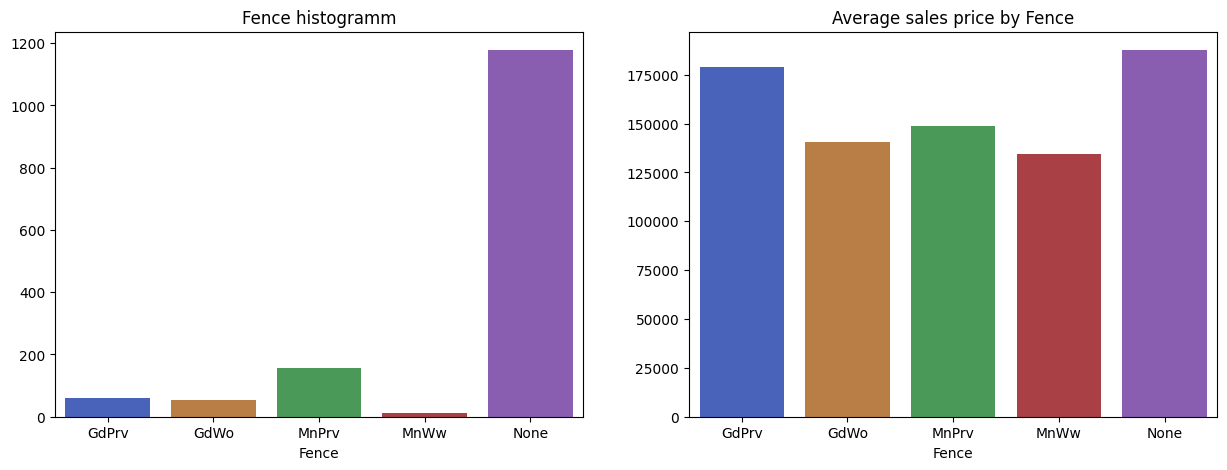

In [91]:
show_distributions_for_cat('Fence')

MiscFeature

In [92]:
df["MiscFeature"].isna().sum()

1405

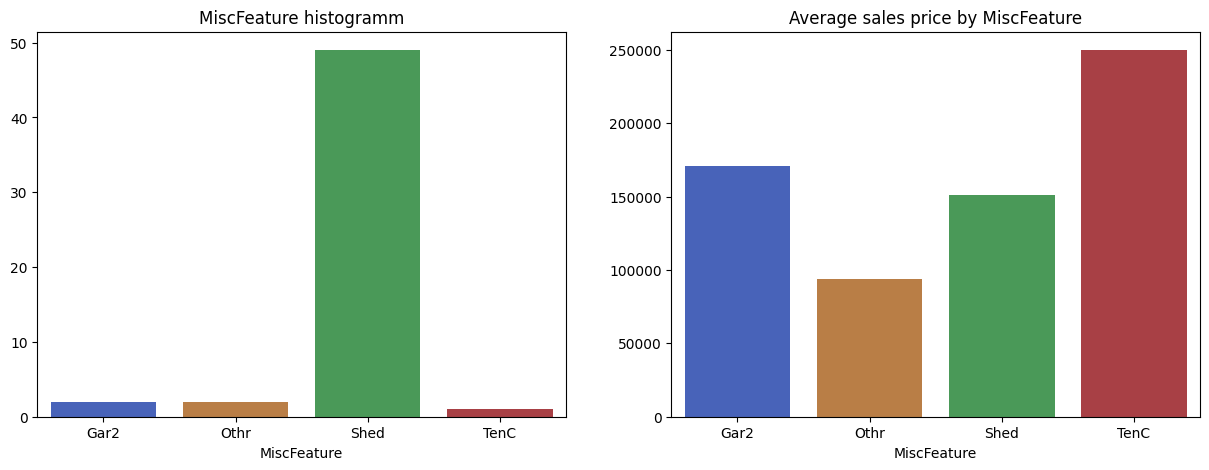

In [93]:
show_distributions_for_cat('MiscFeature')

Almost None varibale

MiscVal

In [94]:
df["MiscVal"].isna().sum()

0

In [96]:
(df["MiscVal"] == 0).sum()

1407

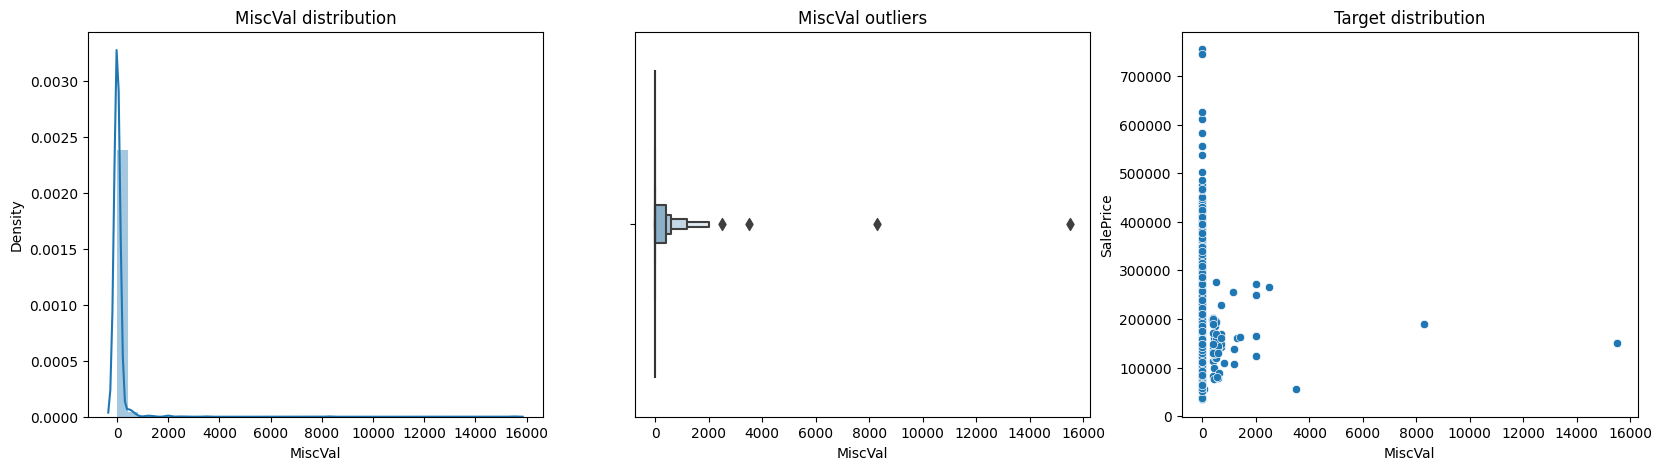

In [95]:
show_distriubutions_for_num('MiscVal')

Almost none var

MoSold

In [99]:
df["YrSold"].isna().sum()

0

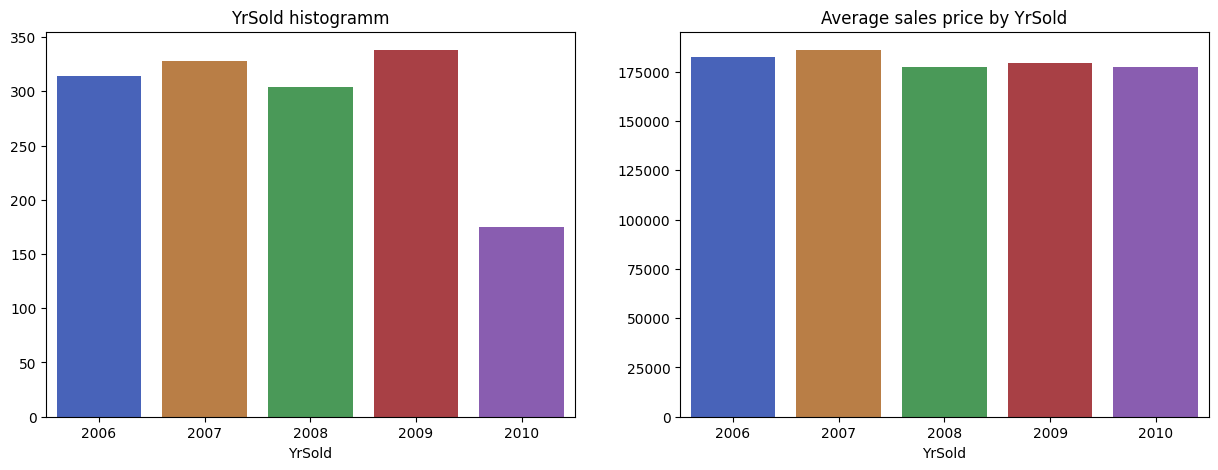

In [100]:
show_distributions_for_cat('YrSold')

Add variable: year >= 2008

SaleType

In [102]:
df["SaleType"].isna().sum()

0

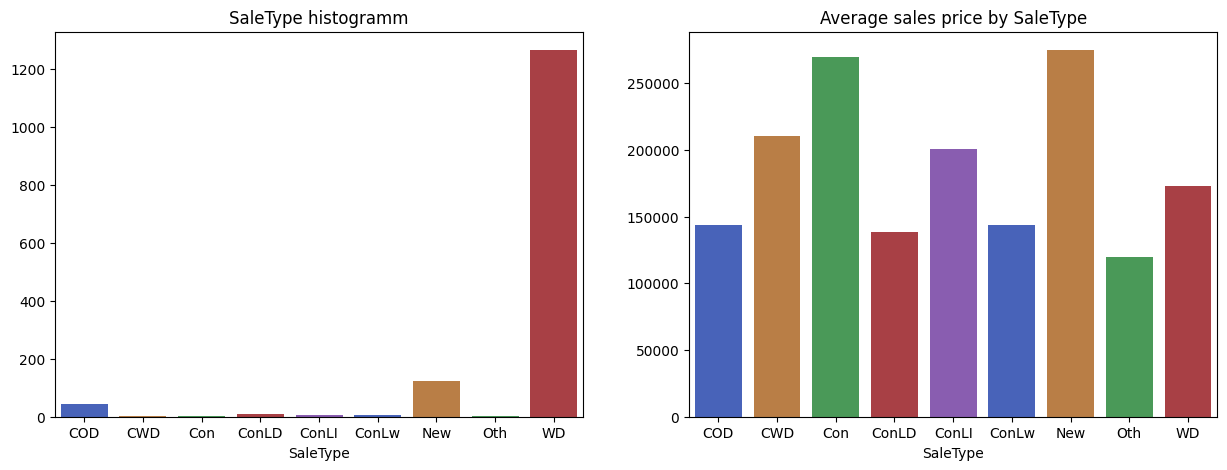

In [103]:
show_distributions_for_cat('SaleType')

SaleCondition

In [104]:
df["SaleCondition"].isna().sum()

0

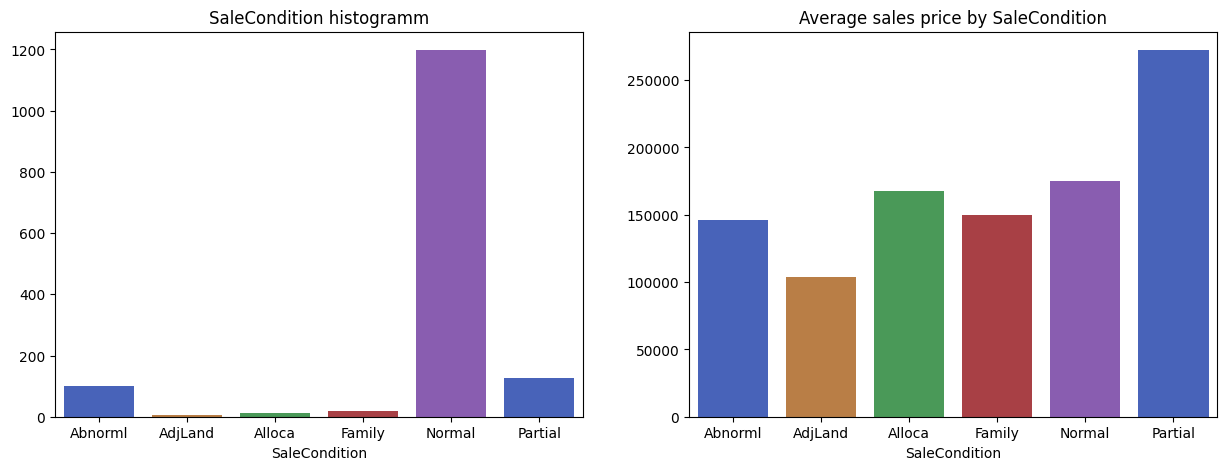

In [105]:
show_distributions_for_cat('SaleCondition')

Target

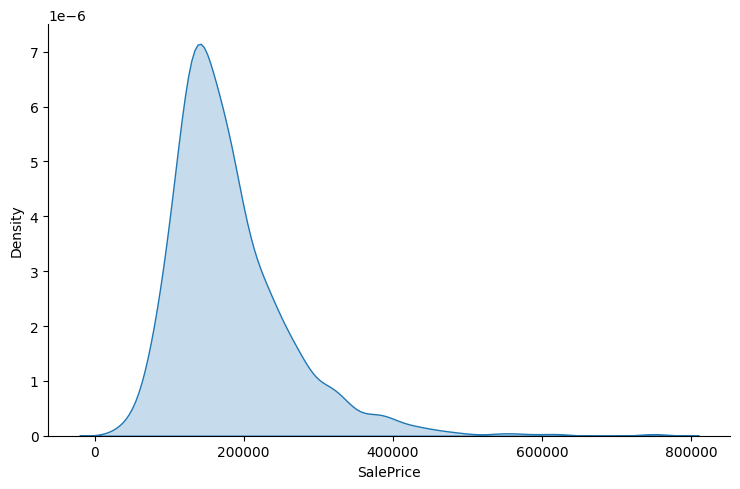

In [108]:
sns.displot(data=df, x='SalePrice', kind='kde', fill=True, palette=sns.color_palette('bright')[:5], height=5, aspect=1.5)

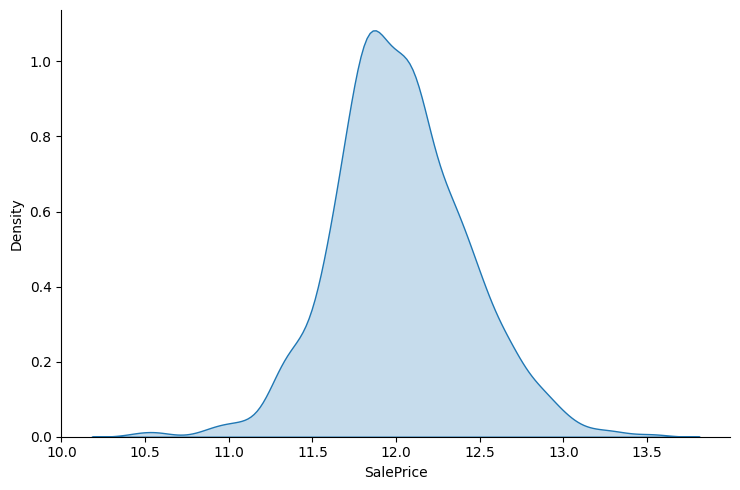

In [109]:
#after log
sns.displot(data=np.log(df.SalePrice),  kind='kde', fill=True, palette=sns.color_palette('bright')[:5], height=5, aspect=1.5)

## Data preprocessing

In [112]:
df["LotConfig"] = df["LotConfig"].replace({"Corner":"C1","FR2":"C1","Inside":"C1"})

In [113]:
df["BldgType"] = df["BldgType"].replace({"TwnhsE":"1Fam","Twnhs":"Duplex","2fmCon":"Duplex"})

In [114]:
df["MasVnrType"].fillna("None", inplace=True)
df["MasVnrArea"].fillna(0, inplace=True)
df["BsmtQual"].fillna("None", inplace=True)
df["BsmtCond"].fillna("None", inplace=True)
df["BsmtExposure"].fillna("None", inplace=True)
df["BsmtFinType1"].fillna("None",inplace=True)
df["BsmtFinType2"].fillna("None",inplace=True)
df["Electrical"].fillna("SBrkr",inplace=True)
df["BsmtFullBath"].replace({3:2},inplace=True)
df["BedroomAbvGr"].replace({8:0},inplace=True)
df = df[df["TotRmsAbvGrd"] < 14]
df["FireplaceQu"].fillna("None", inplace=True)
df["GarageType"].fillna("None", inplace=True)
df["GarageFinish"].fillna("None", inplace=True)
df["GarageQual"].fillna("None", inplace=True)
df["GarageCond"].fillna("None", inplace=True)
df["GarageCond"].replace({"Ex":"None","Gd":"None"},inplace=True)
df["Fence"].fillna("None", inplace=True)
df["YrSold2008"] = df["YrSold"] >= 2008

In [115]:
X_train, X_val, y_train, y_val = train_test_split(df.loc[:,~df.columns.isin([target])], df[target], test_size=0.2, random_state=134)

In [116]:
#special class to encode source data for Pymc model
class PymcTransformer:
    
    def __init__(self, num_cols, cat_cols, nan_substitutor):
        
        #   For numeric - StandardScaler 
        numerical_pipeline_transformer = Pipeline(steps=[
                                                ("scaler", StandardScaler()),
                                        ])

        #   For categorical - OrdinalEncoder
        categorical_pipeline_transformer = Pipeline(steps=[
            ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.int)),

        ])        
        
        data_pipeline_transformer = ColumnTransformer(transformers=[
            ("numerical", numerical_pipeline_transformer, num_cols), 
            ("categorical", categorical_pipeline_transformer, cat_cols),
        ], remainder='drop')
        
        self.transformer = data_pipeline_transformer
        self.nan_substitutor = nan_substitutor
    
    
    def fit_transform(self, df: pd.DataFrame):
        self.transformer.fit(df)
        return self.__transform_encoded(df)

    
    def transform(self, df: pd.DataFrame):
        return self.__transform_encoded(df)

    
    def __transform_encoded(self, df: pd.DataFrame):
        result_data_num = []
        result_data_cat = []
        result_features = {}
        
        transformed = self.transformer.transform(df)
        features = self.transformer.get_feature_names_out()
        num_index = 0
        cat_index = 0
        
        for i in range(len(features)):
            
            f_vals = transformed[:,i]
            f_name = features[i]

            if f_name.startswith("numerical__"):
                f_name = f_name[11:]
                if np.isnan(f_vals).sum() > 0:
                    f_vals[np.isnan(f_vals)] = self.nan_substitutor
                    f_vals = np.ma.masked_values(f_vals, value=self.nan_substitutor)
            
                result_data_num.append(f_vals)
                result_features[f_name] = num_index
                num_index += 1
                        
            if f_name.startswith("categorical__"):
                f_name = f_name[13:]
                f_vals = f_vals.astype(np.int)
                f_vals[f_vals == -1] = np.max(f_vals) + 1 #handle unknown values
                result_data_cat.append(f_vals)
                result_features[f_name] = cat_index
                cat_index += 1
        
        return result_data_num, result_data_cat, result_features
        
        

In [117]:
tr = PymcTransformer(num_cols, cat_cols, -10)

In [118]:
#encode data with Pymc transformer
pymc_vals_num, pymc_vals_cat, pymc_names = tr.fit_transform(X_train)

In [119]:
#encode target to avoid skeweness
y = np.log(y_train.values)

### Modeling

In [158]:

with Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement

    data = Data("data", pymc_vals_num)
    data_cat = Data("data_cat", pymc_vals_cat)

   
    # Define priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal("intercept", mu=0, sigma=100.0)
    
    x_coeff_lot_frontage = Normal("x_coeff_lot_frontage", 0, sigma=100.0)
    x_coeff_lot_area = Normal("x_coeff_lot_area", mu=0, sigma=100.0)
     
    #Imputation of x_coeff_lot_frontage missing values
    lot_frontage_imputed_mu = Normal("lot_frontage_imputed_mu", 0, sigma=8.0)
    lot_frontage_imputed_sigma = HalfCauchy("lot_frontage_imputed_sigma", beta=8.0, testval=1.0)
    lot_frontage_imputed = Normal("lot_frontage_imputed", lot_frontage_imputed_mu, sigma=lot_frontage_imputed_sigma, observed=data[pymc_names["LotFrontage"]])
    
    #mssubclass
    cat_mssubClass = Normal('cat_mssubClass',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["MSSubClass"]]))+1)
    
    #MSZoning
    cat_msZoning = Normal('cat_msZoning',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["MSZoning"]]))+1)

    #Street
    cat_street = Normal('cat_street',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Street"]]))+1)
    
    #LotShape
    cat_lot_shape = Normal('cat_lot_shape',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["LotShape"]]))+1)
    
    #LandContour
    cat_land_contour = Normal('cat_land_contour',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["LandContour"]]))+1)
    
    #LotConfig
    cat_lot_config = Normal('cat_lot_config',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["LotConfig"]]))+1)
    
    #LandSlope
    cat_land_slope = Normal('cat_land_slope',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["LandSlope"]]))+1)
    
    #Neighborhood
    cat_nbh = Normal('cat_nbh',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Neighborhood"]]))+1)
    
    #Condidtion1
    cat_cond1 = Normal('cat_cond1',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Condition1"]]))+1)
    
    #BldgType
    cat_bldg = Normal('cat_bldg',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BldgType"]]))+1)
    
    #HouseStyle
    cat_house_style = Normal('cat_house_style',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["HouseStyle"]]))+1)

    #OverallQual
    cat_ov_qual = Normal('cat_ov_qual',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["OverallQual"]]))+1)
    
    #OverallCond
    cat_ov_cond = Normal('cat_ov_cond',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["OverallCond"]]))+1)
    
    #RoofStyle
    cat_roof_style = Normal('cat_roof_style',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["RoofStyle"]]))+1)
    
    #Exterior1st
    cat_ext_1 = Normal('cat_ext_1',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Exterior1st"]]))+1)

    #Exterior2nd
    cat_ext_2 = Normal('cat_ext_2',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Exterior2nd"]]))+1)
    
    #MasVnrType
    cat_mas_vnr = Normal('cat_mas_vnr',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["MasVnrType"]]))+1)
    
    #MasVnrArea
    x_coeff_mas_vnr_area = Normal("x_coeff_mas_vnr_area", mu=0, sigma=100.0)
    
    #ExterQual
    cat_extr_qual = Normal('cat_extr_qual',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["ExterQual"]]))+1)
    
    #ExterCond
    cat_extr_cond = Normal('cat_extr_cond',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["ExterCond"]]))+1)
    
    #Foundation
    cat_foundation = Normal('cat_foundation',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Foundation"]]))+1)
    
    #BsmtQual
    cat_bsmt_qual = Normal('cat_bsmt_qual',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BsmtQual"]]))+1)
    
    #BsmtCond
    cat_bsmt_cond = Normal('cat_bsmt_cond',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BsmtCond"]]))+1)
    
    #BsmtExposure
    cat_bsmt_exp = Normal('cat_bsmt_exp',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BsmtExposure"]]))+1)

    #BsmtFinType1
    cat_bsmt_ftp = Normal('cat_bsmt_ftp',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BsmtFinType1"]]))+1)
    
    #BsmtFinSF1
    x_bsmt_fin_sf1 = Normal("x_bsmt_fin_sf1", mu=0, sigma=100.0)

    #BsmtFinType2
    cat_bsmt_ftp2 = Normal('cat_bsmt_ftp2',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BsmtFinType2"]]))+1)
    
    #BsmtFinSF2
    x_bsmt_fin_sf2 = Normal("x_bsmt_fin_sf2", mu=0, sigma=100.0)
    
    #BsmtUnfSF
    x_bsmt_unf_sf = Normal("x_bsmt_unf_sf", mu=0, sigma=100.0)
    
    #TotalBsmtSF
    x_ttl_bsmt_sf = Normal("x_ttl_bsmt_sf", mu=0, sigma=100.0)
    
    #HeatingQC
    cat_heating_cq = Normal('cat_heating_cq',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["HeatingQC"]]))+1)
    
    #CentralAir
    cat_air = Normal('cat_air',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["CentralAir"]]))+1)
    
    #Electrical
    cat_elct = Normal('cat_elct',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Electrical"]]))+1)

    #1stFlrSF
    x_1st_flr_sf = Normal("x_1st_flr_sf", mu=0, sigma=100.0)

    #2ndFlrSF
    x_2nd_flr_sf = Normal("x_2nd_flr_sf", mu=0, sigma=100.0)
    
    #GrLivArea
    x_grv_liv_area = Normal("x_grv_liv_area", mu=0, sigma=100.0)
    
    #BsmtFullBath
    cat_bsmt_full_bath = Normal('cat_bsmt_full_bath',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BsmtFullBath"]]))+1)
    
    #FullBath
    cat_full_bath = Normal('cat_full_bath',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["FullBath"]]))+1)
    
    #HalfBath
    cat_half_bath = Normal('cat_half_bath',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["HalfBath"]]))+1)
    
    #BedroomAbvGr
    cat_bedroms_above_gr = Normal('cat_bedroms_above_gr',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["BedroomAbvGr"]]))+1)
    
    #KitchenQual
    cat_kitchen_qual = Normal('cat_kitchen_qual',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["KitchenQual"]]))+1)
    
    #TotRmsAbvGrd
    x_tot_rms_abv_grd = Normal("x_tot_rms_abv_grd", mu=0, sigma=100.0)
    
    #Fireplaces
    x_fireplaces = Normal("x_fireplaces", mu=0, sigma=100.0)
    
    #FireplaceQu
    cat_fireplace_qual = Normal('cat_fireplace_qual',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["FireplaceQu"]]))+1)
    
    #GarageType
    cat_garage_type = Normal('cat_garage_type',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["GarageType"]]))+1)
    
    #GarageFinish
    cat_garage_finish = Normal('cat_garage_finish',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["GarageFinish"]]))+1)
    
    #GarageCars
    x_garager_cars = Normal("x_garager_cars", mu=0, sigma=100.0)
    
    #GarageArea
    x_garage_area = Normal("x_garage_area", mu=0, sigma=100.0)
    
    #GarageQual
    cat_garage_qual = Normal('cat_garage_qual',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["GarageQual"]]))+1)
    
    #GarageCond
    cat_garage_cond = Normal('cat_garage_cond',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["GarageCond"]]))+1)
    
    #PavedDrive
    cat_paved_drive = Normal('cat_paved_drive',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["PavedDrive"]]))+1)
    
    #WoodDeckSF
    x_wood_desk_sf = Normal("x_wood_desk_sf", mu=0, sigma=100.0)
    
    #OpenPorchSF
    x_open_porch_sf = Normal("x_open_porch_sf", mu=0, sigma=100.0)
    
    #EnclosedPorch
    x_enc_porch_sf = Normal("x_enc_porch_sf", mu=0, sigma=100.0)
    
    #ScreenPorch
    x_screen_porch_sf = Normal("x_screen_porch_sf", mu=0, sigma=100.0)
    
    #Fence
    cat_fence = Normal('cat_fence',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["Fence"]]))+1)
    
    #YrSold2008
    cat_2008 = Normal('cat_2008',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["YrSold2008"]]))+1)
    
    #SaleType
    cat_sale_type = Normal('cat_sale_type',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["SaleType"]]))+1)
    
    #SaleCondition
    cat_sale_cond = Normal('cat_sale_cond',0, 1, shape=len(np.unique(pymc_vals_cat[pymc_names["SaleCondition"]]))+1)
    
    # Define likelihood
    likelihood = Normal("y", mu=intercept + x_coeff_lot_frontage * lot_frontage_imputed \
                        +  x_coeff_lot_area * data[pymc_names["LotArea"]] \
                        + cat_mssubClass[data_cat[pymc_names["MSSubClass"]]] \
                        + cat_msZoning[data_cat[pymc_names["MSZoning"]]] \
                        + cat_street[data_cat[pymc_names["Street"]]] \
                        + cat_lot_shape[data_cat[pymc_names["LotShape"]]] \
                        + cat_land_contour[data_cat[pymc_names["LandContour"]]] \
                        + cat_lot_config[data_cat[pymc_names["LotConfig"]]] \
                        + cat_land_slope[data_cat[pymc_names["LandSlope"]]] \
                        + cat_nbh[data_cat[pymc_names["Neighborhood"]]] \
                        + cat_cond1[data_cat[pymc_names["Condition1"]]] \
                        + cat_bldg[data_cat[pymc_names["BldgType"]]] \
                        + cat_house_style[data_cat[pymc_names["HouseStyle"]]] \
                        + cat_ov_qual[data_cat[pymc_names["OverallQual"]]] \
                        + cat_ov_cond[data_cat[pymc_names["OverallCond"]]] \
                        + cat_roof_style[data_cat[pymc_names["RoofStyle"]]] \
                        + cat_ext_1[data_cat[pymc_names["Exterior1st"]]] \
                        + cat_ext_2[data_cat[pymc_names["Exterior2nd"]]] \
                        + cat_mas_vnr[data_cat[pymc_names["MasVnrType"]]] \
                        + x_coeff_mas_vnr_area * data[pymc_names["MasVnrArea"]] \
                        + cat_extr_qual[data_cat[pymc_names["ExterQual"]]] \
                        + cat_extr_cond[data_cat[pymc_names["ExterCond"]]] \
                        + cat_foundation[data_cat[pymc_names["Foundation"]]] \
                        + cat_bsmt_qual[data_cat[pymc_names["BsmtQual"]]] \
                        + cat_bsmt_cond[data_cat[pymc_names["BsmtCond"]]] \
                        + cat_bsmt_exp[data_cat[pymc_names["BsmtExposure"]]] \
                        + cat_bsmt_ftp[data_cat[pymc_names["BsmtFinType1"]]] \
                        + x_bsmt_fin_sf1 * data[pymc_names["BsmtFinSF1"]] \
                        + cat_bsmt_ftp2[data_cat[pymc_names["BsmtFinType2"]]] \
                        + x_bsmt_fin_sf2 * data[pymc_names["BsmtFinSF2"]] \
                        + x_bsmt_unf_sf * data[pymc_names["BsmtUnfSF"]] \
                        + x_ttl_bsmt_sf * data[pymc_names["TotalBsmtSF"]] \
                        + cat_heating_cq[data_cat[pymc_names["HeatingQC"]]] \
                        + cat_air[data_cat[pymc_names["CentralAir"]]] \
                        + cat_elct[data_cat[pymc_names["Electrical"]]] \
                        + x_1st_flr_sf * data[pymc_names["1stFlrSF"]] \
                        + x_2nd_flr_sf * data[pymc_names["2ndFlrSF"]] \
                        + x_grv_liv_area * data[pymc_names["GrLivArea"]] \
                        + cat_bsmt_full_bath[data_cat[pymc_names["BsmtFullBath"]]] \
                        + cat_full_bath[data_cat[pymc_names["FullBath"]]] \
                        + cat_half_bath[data_cat[pymc_names["HalfBath"]]] \
                        + cat_bedroms_above_gr[data_cat[pymc_names["BedroomAbvGr"]]] \
                        + cat_kitchen_qual[data_cat[pymc_names["KitchenQual"]]] \
                        + x_tot_rms_abv_grd * data[pymc_names["TotRmsAbvGrd"]] \
                        + x_fireplaces * data[pymc_names["Fireplaces"]] \
                        + cat_fireplace_qual[data_cat[pymc_names["FireplaceQu"]]] \
                        + cat_garage_type[data_cat[pymc_names["GarageType"]]] \
                        + cat_garage_finish[data_cat[pymc_names["GarageFinish"]]] \
                        + x_garager_cars * data[pymc_names["GarageCars"]] \
                        + x_garage_area * data[pymc_names["GarageArea"]] \
                        + cat_garage_qual[data_cat[pymc_names["GarageQual"]]] \
                        + cat_garage_cond[data_cat[pymc_names["GarageCond"]]] \
                        + cat_paved_drive[data_cat[pymc_names["PavedDrive"]]] \
                        + x_wood_desk_sf * data[pymc_names["WoodDeckSF"]] \
                        + x_open_porch_sf * data[pymc_names["OpenPorchSF"]] \
                        + x_enc_porch_sf * data[pymc_names["EnclosedPorch"]] \
                        + x_screen_porch_sf * data[pymc_names["ScreenPorch"]] \
                        + cat_fence[data_cat[pymc_names["Fence"]]] \
                        + cat_2008[data_cat[pymc_names["YrSold2008"]]] \
                        + cat_sale_type[data_cat[pymc_names["SaleType"]]] \
                        + cat_sale_cond[data_cat[pymc_names["SaleCondition"]]] \
                        
                        , sigma=sigma, observed=y)
    
    #trace!
    trace = sample(4000, tune=4000, chains=2, cores=16)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 16 jobs)
NUTS: [cat_sale_cond, cat_sale_type, cat_2008, cat_fence, x_screen_porch_sf, x_enc_porch_sf, x_open_porch_sf, x_wood_desk_sf, cat_paved_drive, cat_garage_cond, cat_garage_qual, x_garage_area, x_garager_cars, cat_garage_finish, cat_garage_type, cat_fireplace_qual, x_fireplaces, x_tot_rms_abv_grd, cat_kitchen_qual, cat_bedroms_above_gr, cat_half_bath, cat_full_bath, cat_bsmt_full_bath, x_grv_liv_area, x_2nd_flr_sf, x_1st_flr_sf, cat_elct, cat_air, cat_heating_cq, x_ttl_bsmt_sf, x_bsmt_unf_sf, x_bsmt_fin_sf2, cat_bsmt_ftp2, x_bsmt_fin_sf1, cat_bsmt_ftp, cat_bsmt_exp, cat_bsmt_cond, cat_bsmt_qual, cat_foundation, cat_extr_cond, cat_extr_qual, x_coeff_mas_vnr_area, cat_mas_vnr, cat_ext_2, cat_ext_1, cat_roof_style, cat_ov_cond, cat_ov_qual, cat_house_style, cat_bldg, cat_cond1, cat_nbh, cat_land_slope, cat_lot_config, cat_land_contour, cat_lot_shape, cat_street, cat_msZoni

Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 10961 seconds.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8987688025232251, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Plot some distributions for model variables and posterior distribution

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'x_coeff_lot_frontage'}>,
        <AxesSubplot:title={'center':'x_coeff_lot_frontage'}>],
       [<AxesSubplot:title={'center':'x_coeff_lot_area'}>,
        <AxesSubplot:title={'center':'x_coeff_lot_area'}>],
       [<AxesSubplot:title={'center':'lot_frontage_imputed_mu'}>,
        <AxesSubplot:title={'center':'lot_frontage_imputed_mu'}>],
       [<AxesSubplot:title={'center':'cat_mssubClass'}>,
        <AxesSubplot:title={'center':'cat_mssubClass'}>],
       [<AxesSubplot:title={'center':'cat_msZoning'}>,
        <AxesSubplot:title={'center':'cat_msZoning'}>],
       [<AxesSubplot:title={'center':'cat_street'}>,
        <AxesSubplot:title={'center':'cat_street'}>],
       [<AxesSubplot:title={'center':'cat_lot_shape'}>,
        <AxesSubplot:title={'center':'cat_lot_shape'}>],
       [<AxesSubplot:title={'center':'cat_land_contour'}>,
        <Ax

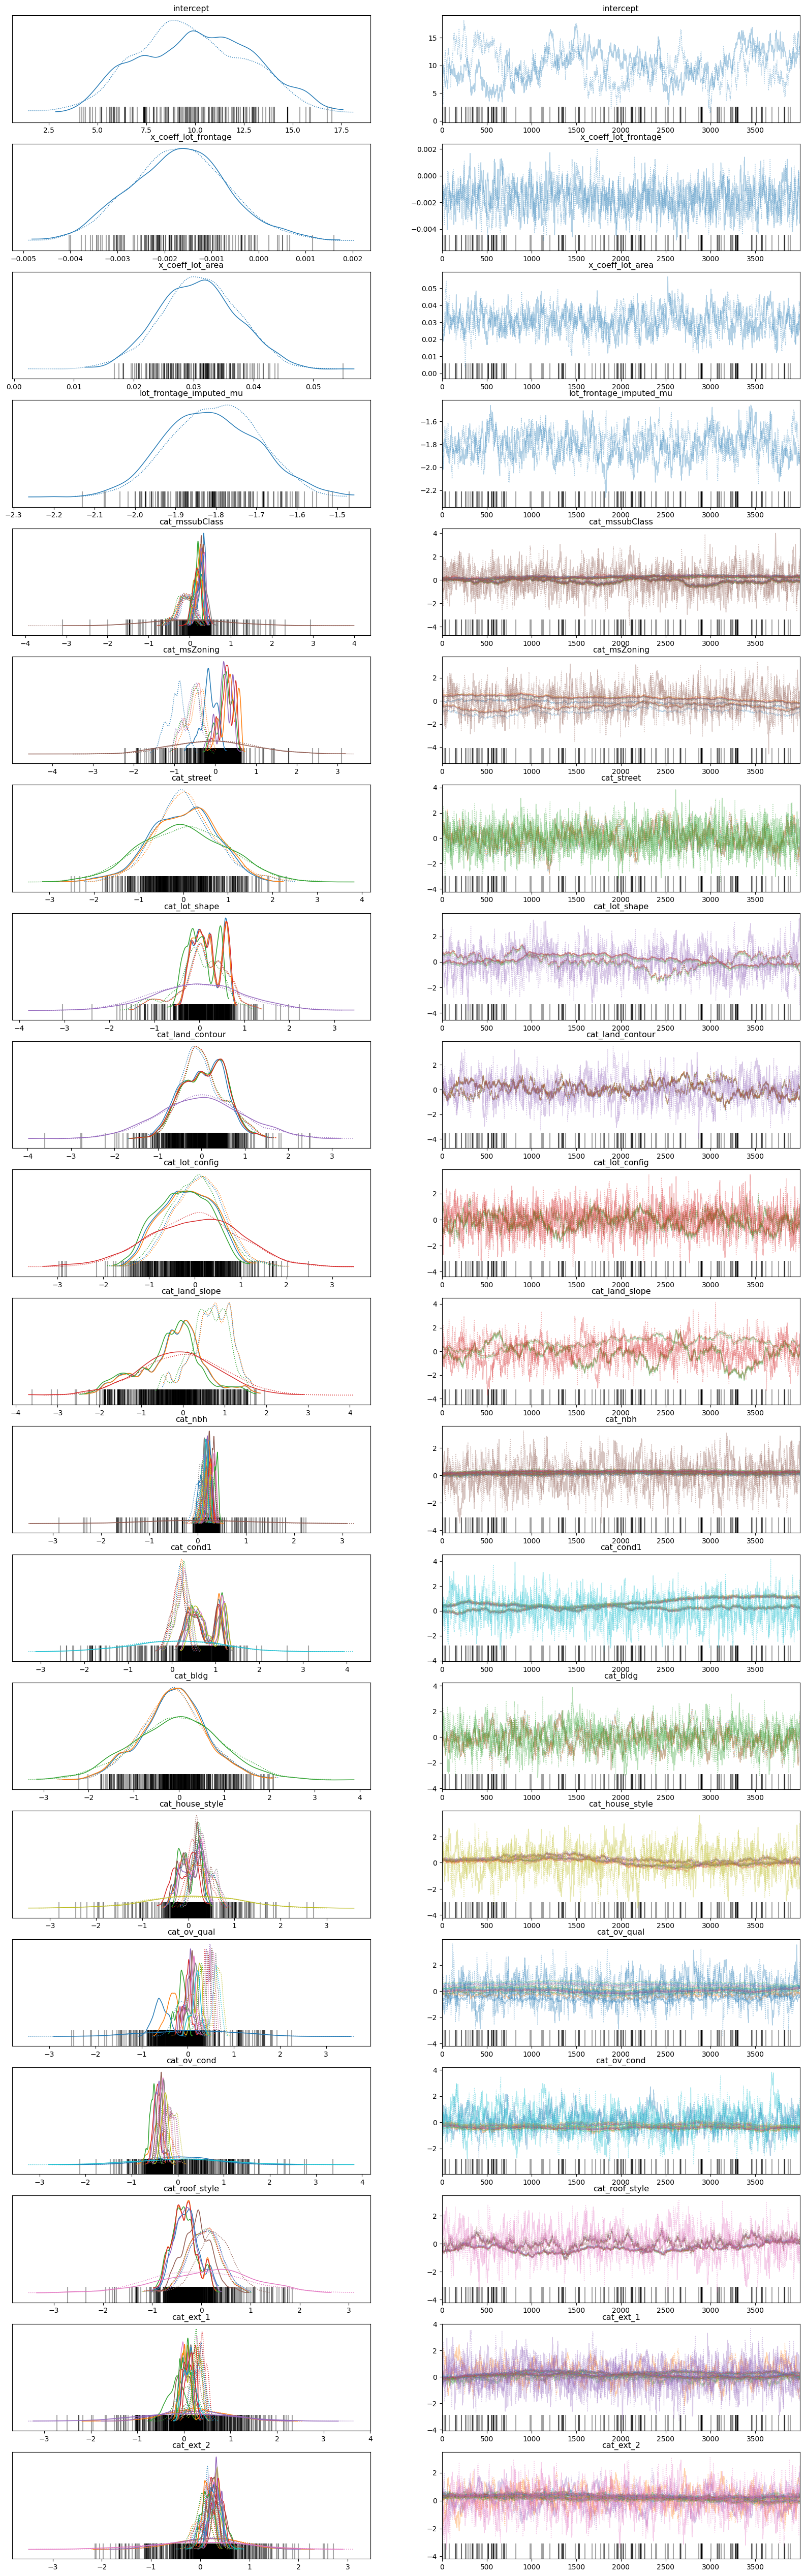

In [159]:
az.plot_trace(trace, figsize=(20,65))

In [160]:
with model:
     ppc = sample_posterior_predictive(
        trace, var_names=["y"], random_seed=RANDOM_SEED
    )

<AxesSubplot:xlabel='y / y'>

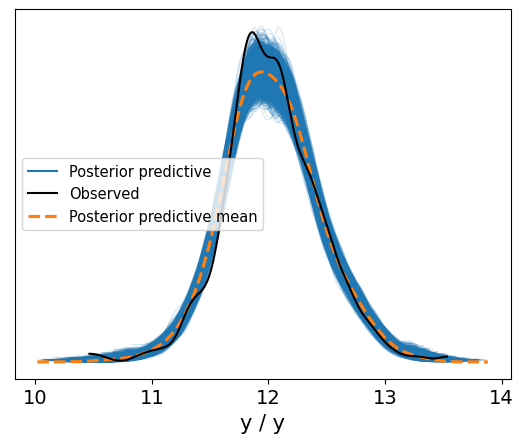

In [161]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), var_names=["y"])


### Evaluation

In [152]:
#encode our eval set
pymc_vals_num_eval, pymc_vals_cat_eval, pymc_names_eval = tr.transform(X_val)

In [162]:
#get predictions for encoded eval set
with model:
    # update values of predictors with eval data:
    set_data({"data": pymc_vals_num_eval, "data_cat":pymc_vals_cat_eval})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = sample_posterior_predictive(
        trace, var_names=["y"], random_seed=RANDOM_SEED
    )
    model_preds = posterior_predictive["y"]

In [163]:
#call exp to restore original sales price
predicted_sales = np.exp(model_preds).mean(0)

In [164]:
print("R2 score for eval set : {0}".format(r2_score(y_val, predicted_sales)))

R2 score for eval set : 0.7151681690360023


In [165]:
print("RMSE for eval set : {0}".format(mean_squared_error(np.log(y_val), np.log(predicted_sales), squared=False)))

RMSE for eval set : 0.15927249878627583


Let's plot our predictions

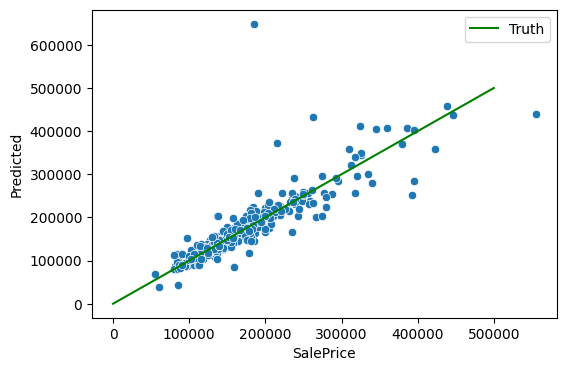

In [166]:
x_plot = np.linspace(0, 500000, 100)

fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=y_val, y=predicted_sales, ax=ax)
p2 = sns.lineplot(x=x_plot, y=x_plot, color='g', ax=ax, label="Truth")

ax.set_ylabel("Predicted")
plt.show()


### Pymc regression model showes good results with R2 = 0.7152 and RMSE = 0.1592

### Compare with classic linear regression

In [169]:
numerical_pipeline_transformer = Pipeline(steps=[
                                        ("imputer", SimpleImputer(strategy='mean')),
                                        ("scaler", StandardScaler()),
                                    ])


categorical_pipeline_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

data_pipeline_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_pipeline_transformer, num_cols), 
    ("categorical", categorical_pipeline_transformer, cat_cols),
], remainder='drop')


In [170]:
preprocessor = Pipeline(steps=[("data_transformer", data_pipeline_transformer)])

In [181]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [182]:
model_classic = LinearRegression()

regressor_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', model_classic)
])

In [183]:
scorer = make_scorer(r2_score)
scores = cross_val_score(regressor_pipeline, X_train, y_train, scoring=scorer, cv=3, n_jobs=-1)

In [185]:
np.mean(scores)

0.7825359301627964

In [188]:
regressor_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['LotFrontage',
                                                                    'LotArea',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    '1stFlrSF',
                                                                    '2ndFlrSF',
                                                                    'GrLivArea',
                                                                    'TotRmsAbvGrd',
                                                                    'Fireplaces',
                                                                    'GarageCars',
                                                                    'Ga...
                                                                    'LandSlope',
                                                                    'Neighborhood',
                                                                    'Condition1',
                                                                    'BldgType',
                                                                    'HouseStyle',
                                                                    'OverallCond',
                                                                    'OverallQual',
                                                                    'RoofStyle',
                                                                    'Exterior1st',
                                                                    'Exterior2nd',
                                                                    'MasVnrType',
                                                                    'ExterQual',
                                                                    'ExterCond',
                                                                    'Foundation',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'HeatingQC',
                                                                    'CentralAir',
                                                                    'Electrical',
                                                                    'BsmtFullBath',
                                                                    'FullBath', ...])]))])),
                ('model', LinearRegression())])

In [189]:
predicted_classic = regressor_pipeline.predict(X_val)

In [192]:
print("r2 score for validation {}".format(r2_score(y_val, predicted_classic)))

r2 score for validation 0.7905455555298425


In [193]:
print("RMSE for eval set : {0}".format(mean_squared_error(np.log(y_val), np.log(predicted_classic), squared=False)))

RMSE for eval set : 0.16504792410140057


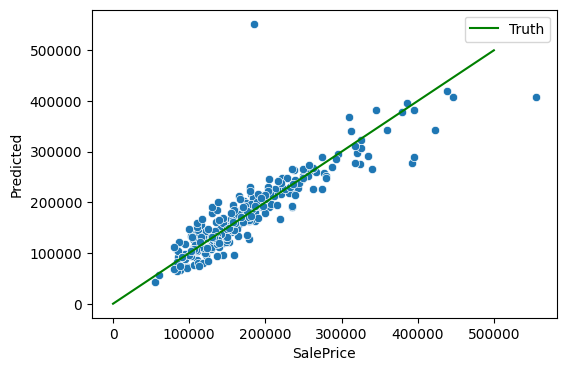

In [194]:
x_plot = np.linspace(0, 500000, 100)

fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=y_val, y=predicted_classic, ax=ax)
p2 = sns.lineplot(x=x_plot, y=x_plot, color='g', ax=ax, label="Truth")

ax.set_ylabel("Predicted")
plt.show()


### Summary

Было проведена реализация модели генерализованной линейной регрессии через веротяностное моделирование параметров с помощью pymc3
На валидации получены оценки: R2 = 0.7152 and RMSE = 0.1592 , время моделирования около 3 часов

Для сравнения была проведена оценка классической линейной регрессией из набора skleran
На валидации получены оценки: R2 = 0.79 and RMSE = 0.165 , время моделирования около 3 секунд ) 

Визуально данные распределены лучше на классической линейной регрессии.. Возможно в версии pymc следовало более тщательно подбирать прайеры для параметров регрессии..
